In [2]:
%load_ext autoreload
%autoreload 2

import time

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=1000)
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
from tqdm import tqdm

# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences



In [3]:
# Define global var
threshold = 0.01
max_iter = 1000000

list_dev = []
num_neg_jac_init = []
num_neg_jac = []
time_taken = []
full_start = time.time()

## Full SLSQP

In [4]:
# Define the objective function
def objective(phi, phi_init, A_, b_):
    return np.linalg.norm(A_ @ phi - b_)**2

# Define the objective function

def objectiveEuc(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init)

def objectiveEuc2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init) + np.linalg.norm(A_ @ phi - b_)

def objectiveManh(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init, ord=1)

def objectiveManh2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init, ord=1) + np.linalg.norm(A_ @ phi - b_)


In [5]:
# jacobian functions

def jacobian_det2D(phi_xy):
    deformation = np.zeros((3,1, *phi_xy.shape[-2:]))
    deformation[2] = phi_xy[1]
    deformation[1] = phi_xy[0]
    return jacobian.sitk_jacobian_determinant(deformation)

def jacobian_constraint(phi_xy, slice_shape, y_offset):
    deformation = np.zeros((3,1, *slice_shape[-2:]))
    deformation[2] = phi_xy[:y_offset].reshape((slice_shape[2], slice_shape[3]))
    deformation[1] = phi_xy[y_offset:].reshape((slice_shape[2], slice_shape[3]))    
    return jacobian.sitk_jacobian_determinant(deformation).flatten()

In [31]:
def full_slsqp(deformation_i, methodName='SLSQP', save_path=None):
    '''perform SLSQP on full image'''
    time_start = time.time()

    slice_shape = deformation_i.shape

    # this phi will be updated iteratively
    phi_init = np.zeros((2, *deformation_i.shape[-2:]))
    phi_init[1] = deformation_i[-1]
    phi_init[0] = deformation_i[-2]
    print(f'deformation_i shape: {deformation_i.shape}, phi_init shape: {phi_init.shape}')
    
    phi_init_flat = np.concatenate([phi_init[1].flatten(), phi_init[0].flatten()])
    phi = phi_init.copy()

    # collect indices with -ve Jacobians into a list in a sorted fashion
    J_init = jacobian_det2D(phi_init)
    
    y_offset = J_init.size

    nonlinear_constraints = NonlinearConstraint(lambda phi1: jacobian_constraint(phi1, slice_shape, y_offset), threshold, np.inf)
    constraints=nonlinear_constraints

    _, A_, b_ = laplacian.compute3DLaplacianFromShape(slice_shape, np.empty((0,3)), np.empty((0,3)))

    result = minimize(lambda phi1: objectiveEuc(phi1, phi_init_flat, A_, b_), phi_init_flat, constraints=constraints, options={'maxiter': max_iter, 'disp': True}, method=methodName)
    if result.success:
        print(f'OP result error: {result.fun}')
    else:
        print("Optimisation failed: ", result.message)


    phi[1] = result.x[:len(result.x) // 2].reshape(slice_shape[-2:])
    phi[0] = result.x[len(result.x) // 2:].reshape(slice_shape[-2:])

    J_final = jacobian_det2D(phi)
    jacobians = [J_init, J_final]

    deviation = np.sqrt(np.sum((phi - phi_init)**2))

    print(f'Deviation from initial = {deviation}')
    print(f'Changed number of -ve jacobians from {(J_init<=0).sum()} to {(J_final<=0).sum()}')

    time_end = time.time()
    print(f'Time taken for full SLSQP optimisation: {time_end-time_start}s')

    # add to global var list
    list_dev.append(deviation)
    num_neg_jac_init.append((J_init<=0).sum())
    num_neg_jac.append((J_final<=0).sum())
    time_taken.append(time_end-time_start)
    
    # Save data from this run
    if save_path is not None:
        # Write the data into a text file
        output_text = f"Settings:\n"
        output_text += f"\tMethod: Full SLSQP\n"
        output_text += f"\tThreshold: {threshold}\n"
        output_text += f"\tMax iterations: {max_iter}\n"
        
        output_text += "Results:\n"
        output_text += f"\tInput deformation field resolution (height x width): {deformation_i.shape[2]} x {deformation_i.shape[3]}\n"
        output_text += f"\tTotal run-time: {time_end - time_start} seconds\n"
        output_text += f"\tFinal L2 error: {deviation}\n"
        output_text += f"\tStarting number of non-positive Jacobian determinants: {(J_init<=0).sum()}\n"
        output_text += f"\tFinal number of non-positive Jacobian determinants: {(J_final<=0).sum()}\n"
        output_text += f"\tFinal Jacobian determinant minimum value: {J_final.min()}\n"
        
        # Save the string to a text file
        with open(save_path.replace('.npy', '.txt'), 'w') as f:
            f.write(output_text) 
            
    return phi, jacobians

## preprocessing and plotting methods

In [28]:
def plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10), save_path=None, title=""):
    jacobian_initial = jacobian_det2D(deformation_i[1:])
    jacobian_final = jacobian_det2D(phi_corrected)

    # print("JACOBIAN SHAPES", jacobian_initial.shape, jacobian_final.shape)

    # Create DataFrame
    data = {
        ("x-def", "min"): [np.min(deformation_i[2,0]), np.min(phi_corrected[1])],
        ("x-def", "max"): [np.max(deformation_i[2,0]), np.max(phi_corrected[1])],
        ("y-def", "min"): [np.min(deformation_i[1,0]), np.min(phi_corrected[0])],
        ("y-def", "max"): [np.max(deformation_i[1,0]), np.max(phi_corrected[0])],
        ("jacobian", "min"): [np.min(jacobian_initial), np.min(jacobian_final)],
        ("jacobian", "max"): [np.max(jacobian_initial), np.max(jacobian_final)]
    }

    row_names = ["initial", "final"]
    df = pd.DataFrame(data, index=row_names)

    # Print table
    print(df)


    # plot initial vs final Jacobian
    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_initial.min(), jacobian_final.min(), -1), vcenter=0, vmax=max(jacobian_initial.max(), jacobian_final.max(), 1))


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    # jacobians are of shape (1,5,5). Use index [0] for 2D plots
    im0 = axs[0,0].imshow(jacobian_initial[0], cmap='seismic', norm=norm, interpolation='nearest')
    im1 = axs[0,1].imshow(jacobian_final[0], cmap='seismic', norm=norm, interpolation='nearest')
    #im2 = axs[1,0].imshow(jacobian_initial[0], cmap='seismic', norm=norm, interpolation='nearest')
    #im3 = axs[1,1].imshow(jacobian_final[0], cmap='seismic', norm=norm, interpolation='nearest')

    """
    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0,0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    """
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation_i.shape[3]), range(deformation_i.shape[2]), indexing='xy')
    print(f'meshgrid shape for plot: {x.shape}')
    
    axs[0,0].set_title('Initial J det')
    #axs[0,0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
    #axs[0,0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
    #axs[0,0].legend()

    axs[0,1].set_title('Final J det')

    axs[1,0].set_title('Initial deformation')
    axs[1,0].quiver(x, y, deformation_i[2,0], -deformation_i[1,0])

    axs[1,1].set_title('Final deformation')
    axs[1,1].quiver(x, y, phi_corrected[1], -phi_corrected[0])

    for i in range(2):
        axs[1,i].invert_yaxis()
    
    #fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.95, 0.5, 0.02, 0.4])
    fig.colorbar(im1, cax=cax)
    
    if save_path is not None:
        plt.savefig(save_path.replace('.npy', '.png'), bbox_inches='tight')
    plt.suptitle(title, fontsize=16)
    plt.show()

In [8]:
def plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP'):
    # assume jacobians is a list of numpy arrays of shape (1, 5, 5)
    # assume msample and fsample are (N, 3) arrays

    num_jacobians = len(jacobians)
    ncols = min(2, num_jacobians)  # wrap at 2 columns
    nrows = (num_jacobians + ncols - 1) // ncols  # ceiling division

    # Compute color normalization
    all_vals = [j[0] for j in jacobians]  # extract 2D arrays from (1,5,5)
    vmin = min(j.min() for j in all_vals)
    vmax = max(j.max() for j in all_vals)
    norm = mcolors.TwoSlopeNorm(vmin=min(vmin, -1), vcenter=0, vmax=max(vmax, 1))

    # Create subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, jac in enumerate(jacobians):
        im = axs[i].imshow(jac[0], cmap='seismic', norm=norm, interpolation='nearest')
        num_negs = np.sum(jac <= 0)
        axs[i].set_title(f'Jacobian #{i}, {num_negs} -ves' if i > 0 else f'Initial J det: {num_negs} -ves')

        if i == 0:
            axs[i].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving', s=10)
            axs[i].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed', s=10)
            axs[i].legend()

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.1, headwidth=3, headlength=5, width=1)
        )

    # Hide any extra axes
    for j in range(len(jacobians), len(axs)):
        axs[j].axis('off')

    # Add colorbar
    # cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    # fig.colorbar(im, cax=cax)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
    

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

def run_lapl_and_correction(fixed_sample, msample, fsample, methodName='SLSQP'):
    '''plot each Jacobian matrix'''
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    print(f'deformation shape: {deformation_i.shape}')    
    phi_corrected, jacobians = full_slsqp(deformation_i, methodName)
    # plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
    plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))
    return phi_corrected, jacobians

## Neg Jdet test cases

#### 9 neg Jdet

Number of negative Jacobians in initial deformation: 9
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.191366964724193
            Iterations: 11
            Function evaluations: 8822
            Gradient evaluations: 11
OP result error: 2.191366964724193
Deviation from initial = 2.191366964724192
Changed number of -ve jacobians from 9 to 0
Time taken for full SLSQP optimisation: 29.285024166107178s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -4.000496  4.000496 -4.996494 -4.709415 -1.053231  2.279721
final   -3.953523  3.944204 -5.989507 -3.964930  0.010000  2.054942
meshgrid shape for plot: (20, 20)


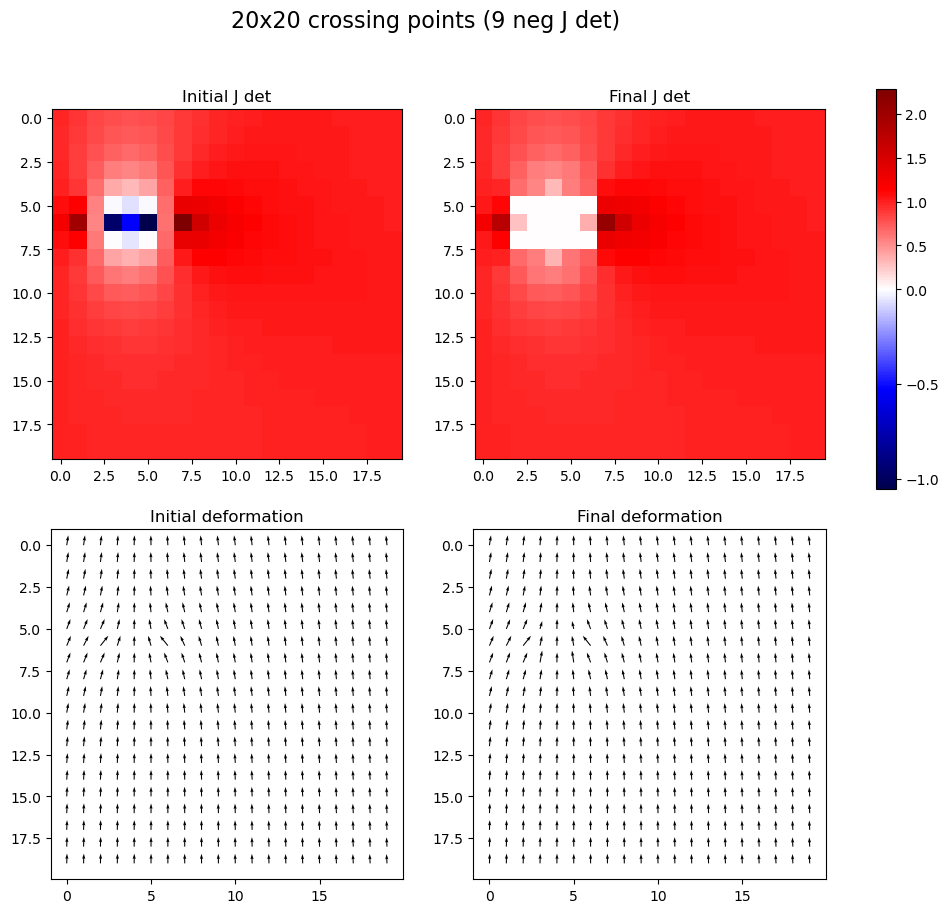

In [38]:
# Data title and where to save the output and results
title = "20x20 crossing points (9 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/009_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 2],
    [0, 1, 6],
])
fsample = np.array([
    [0, 6, 6],
    [0, 6, 2],
])
fixed_sample = np.zeros((1, 20, 20))

deformation_i, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(deformation_i[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, deformation_i, deformation_i, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### 5 neg Jdet

Number of negative Jacobians in initial deformation: 5
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1663611482616238
            Iterations: 8
            Function evaluations: 6421
            Gradient evaluations: 8
OP result error: 1.1663611482616238
Deviation from initial = 1.166361148261625
Changed number of -ve jacobians from 5 to 0
Time taken for full SLSQP optimisation: 21.93301224708557s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -3.000225  3.000225  0.000000  0.000000 -0.680725  1.849371
final   -2.685391  2.602609 -0.383495  0.376519  0.010000  1.661979
meshgrid shape for plot: (20, 20)


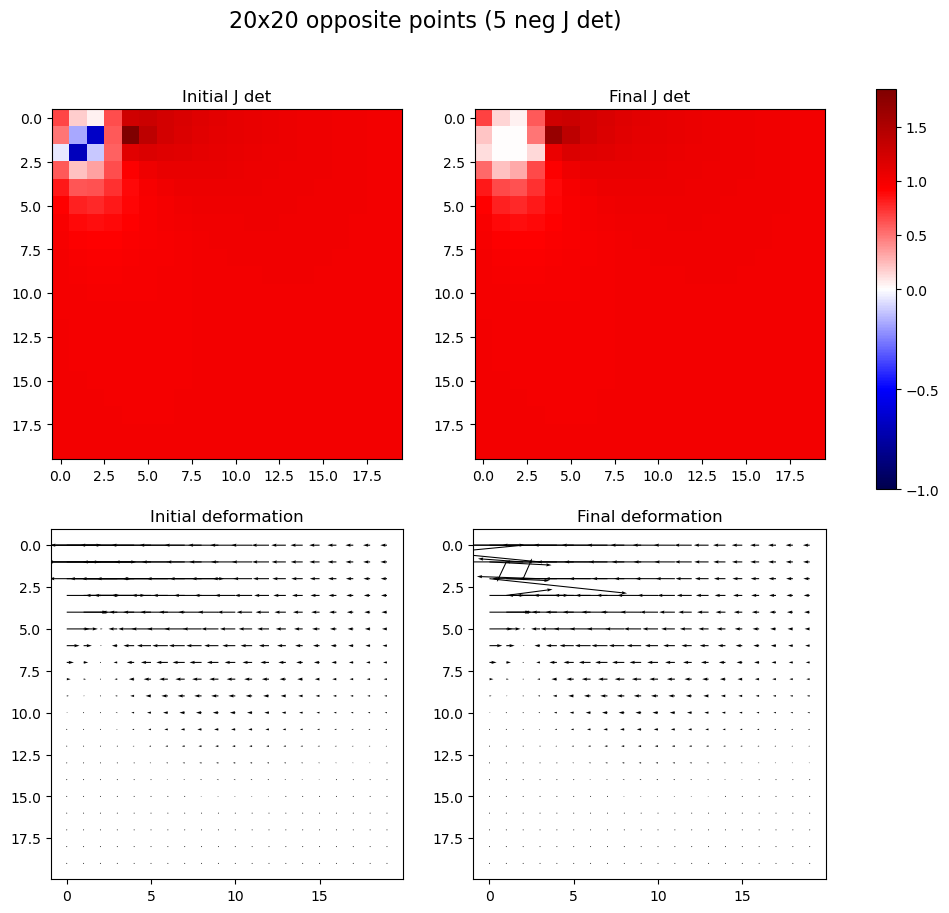

In [53]:
# Data title and where to save the output and results
title = "20x20 opposite points (5 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/005_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])
fixed_sample = np.zeros((1, 20, 20))

deformation_i, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(deformation_i[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, deformation_i, deformation_i, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### 14 neg Jdet

Number of negative Jacobians in initial deformation: 14
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.7305869837565706
            Iterations: 21
            Function evaluations: 16832
            Gradient evaluations: 21
OP result error: 2.7305869837565706
Deviation from initial = 2.730586983756572
Changed number of -ve jacobians from 14 to 0
Time taken for full SLSQP optimisation: 53.63300800323486s
            x-def               y-def           jacobian          
              min       max       min       max      min       max
initial -4.999479  4.999479  0.000000  0.000000 -1.11421  2.222634
final   -4.889587  4.062307 -0.721604  1.027173  0.01000  1.996804
meshgrid shape for plot: (20, 20)


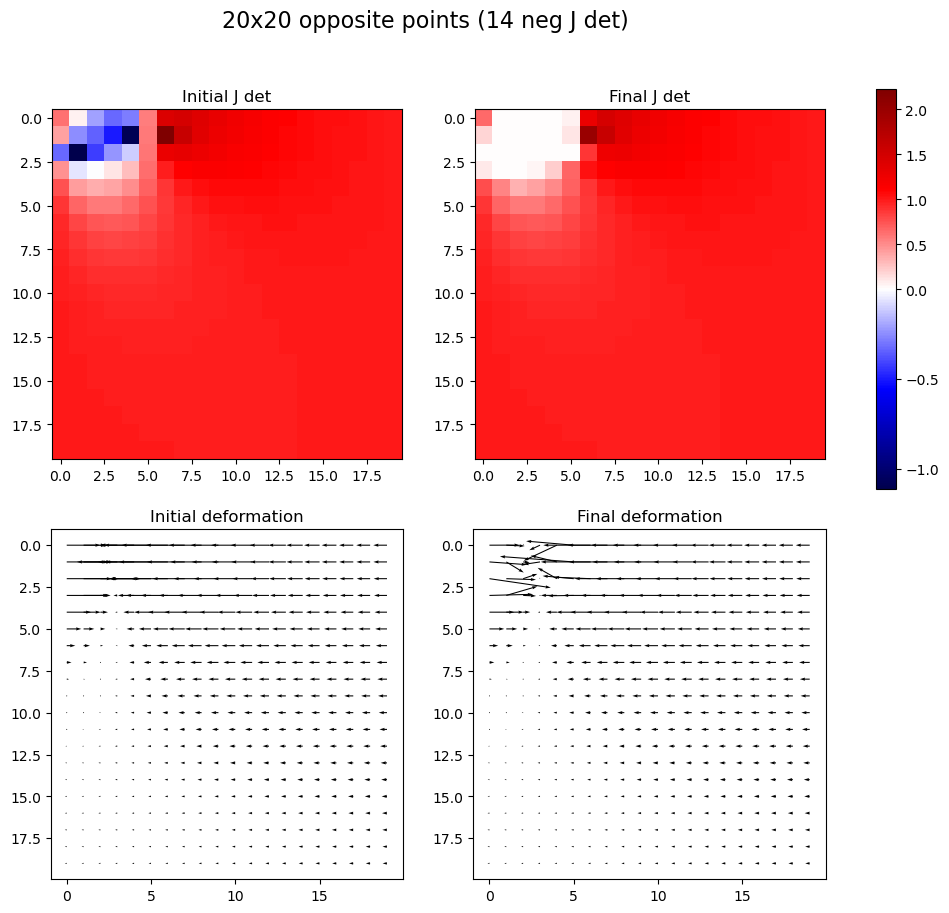

In [54]:
# Data title and where to save the output and results
title = "20x20 opposite points (14 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/014_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 0],
    [0, 2, 5],
])
fsample = np.array([
    [0, 1, 5],
    [0, 2, 0],
])
fixed_sample = np.zeros((1, 20, 20))

deformation_i, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(deformation_i[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, deformation_i, deformation_i, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### 33 neg Jdet

Number of negative Jacobians in initial deformation: 31
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.291333722293336
            Iterations: 94
            Function evaluations: 75389
            Gradient evaluations: 94
OP result error: 5.291333722293336
Deviation from initial = 5.291333722293335
Changed number of -ve jacobians from 31 to 0
Time taken for full SLSQP optimisation: 235.39268445968628s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -9.001778  9.001778  0.000000  0.000000 -1.737686  2.827890
final   -8.892204  9.047565 -1.154125  2.350356  0.010000  1.828611
meshgrid shape for plot: (20, 20)


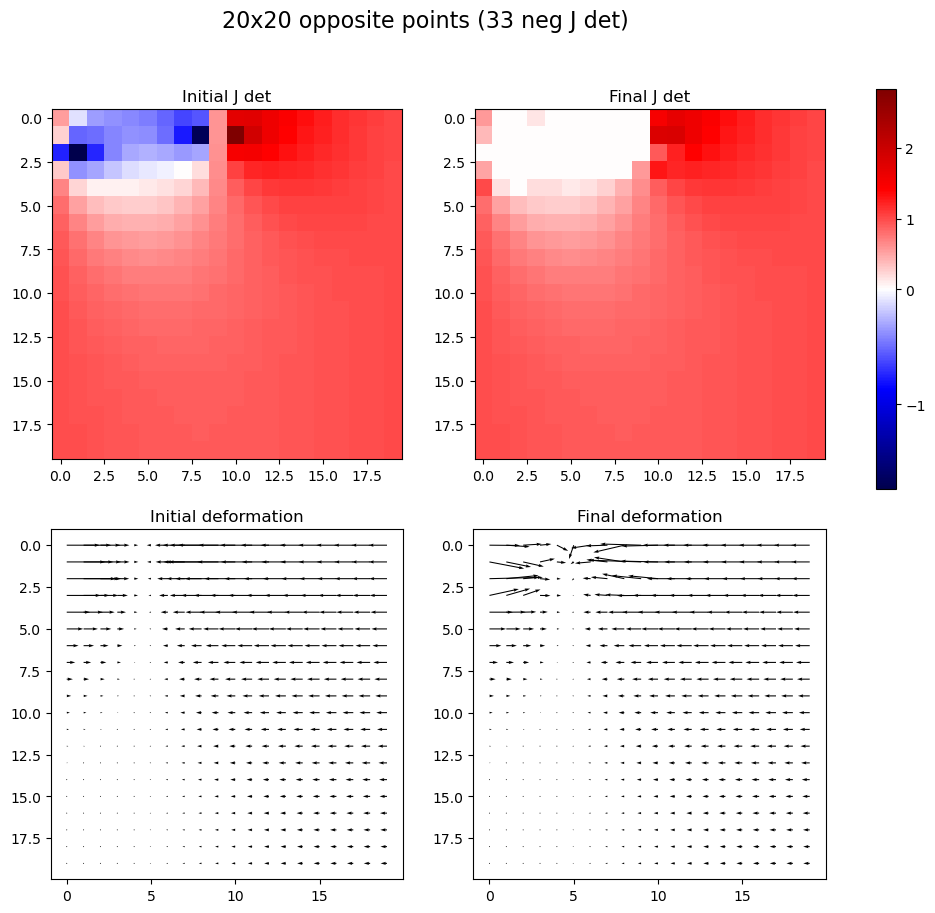

In [55]:
# Data title and where to save the output and results
title = "20x20 opposite points (33 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/033_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 0],
    [0, 2, 9],
])
fsample = np.array([
    [0, 1, 9],
    [0, 2, 0],
])
fixed_sample = np.zeros((1, 20, 20))

deformation_i, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(deformation_i[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, deformation_i, deformation_i, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### 61 neg Jdet

Number of negative Jacobians in initial deformation: 61
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.847614902338681
            Iterations: 73
            Function evaluations: 58490
            Gradient evaluations: 73
OP result error: 7.847614902338681
Deviation from initial = 7.8476149023386785
Changed number of -ve jacobians from 61 to 0
Time taken for full SLSQP optimisation: 178.0353138446808s
             x-def                y-def           jacobian          
               min        max       min      max       min       max
initial -14.000959  14.000959  0.000000  0.00000 -2.351572  3.314009
final   -13.954812  14.066375 -1.728461  2.71668  0.010000  2.069186
meshgrid shape for plot: (20, 20)


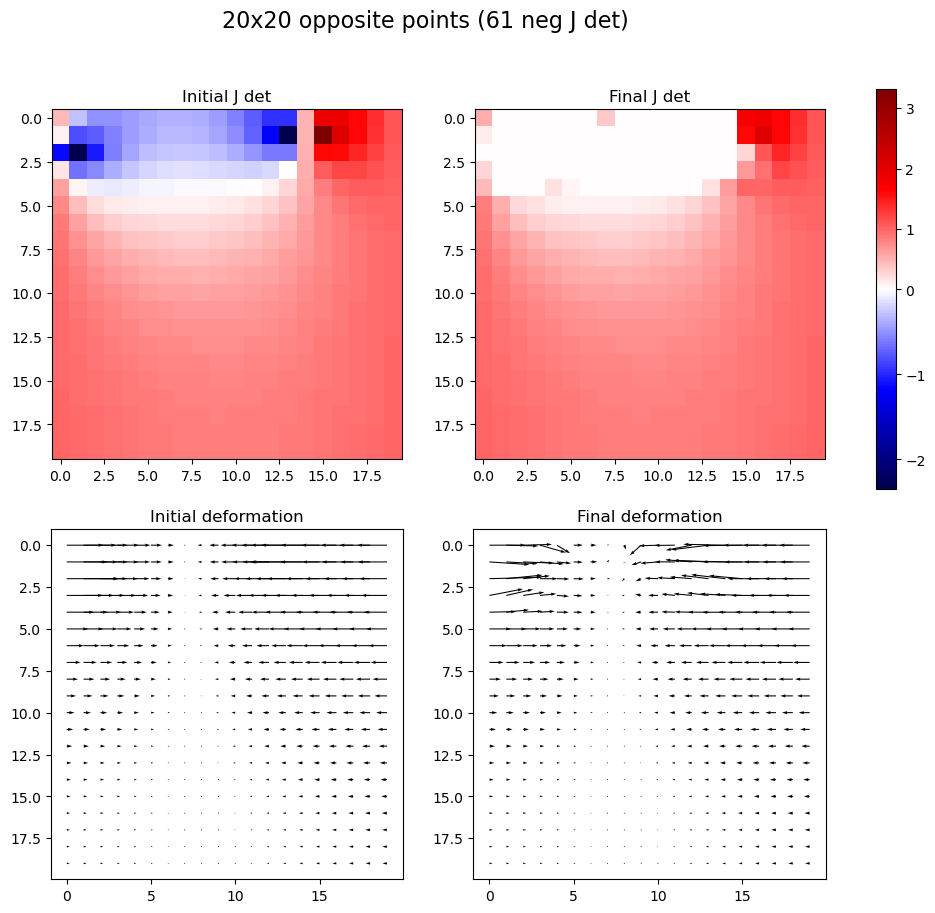

In [41]:
# Data title and where to save the output and results
title = "20x20 opposite points (61 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/061_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 0],
    [0, 2, 14],
])
fsample = np.array([
    [0, 1, 14],
    [0, 2, 0],
])
fixed_sample = np.zeros((1, 20, 20))

deformation_i, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(deformation_i[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, deformation_i, deformation_i, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### 88 neg Jdet

Number of negative Jacobians in initial deformation: 88
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.903282310674765
            Iterations: 64
            Function evaluations: 51275
            Gradient evaluations: 64
OP result error: 9.903282310674765
Deviation from initial = 9.903282310674761
Changed number of -ve jacobians from 88 to 0
Time taken for full SLSQP optimisation: 150.0301489830017s
             x-def               y-def            jacobian          
               min        max      min       max       min       max
initial -18.001705  18.001705  0.00000  0.000000 -2.890413  2.141896
final   -17.914269  18.031399 -1.96129  3.143435  0.010000  0.990398
meshgrid shape for plot: (20, 20)


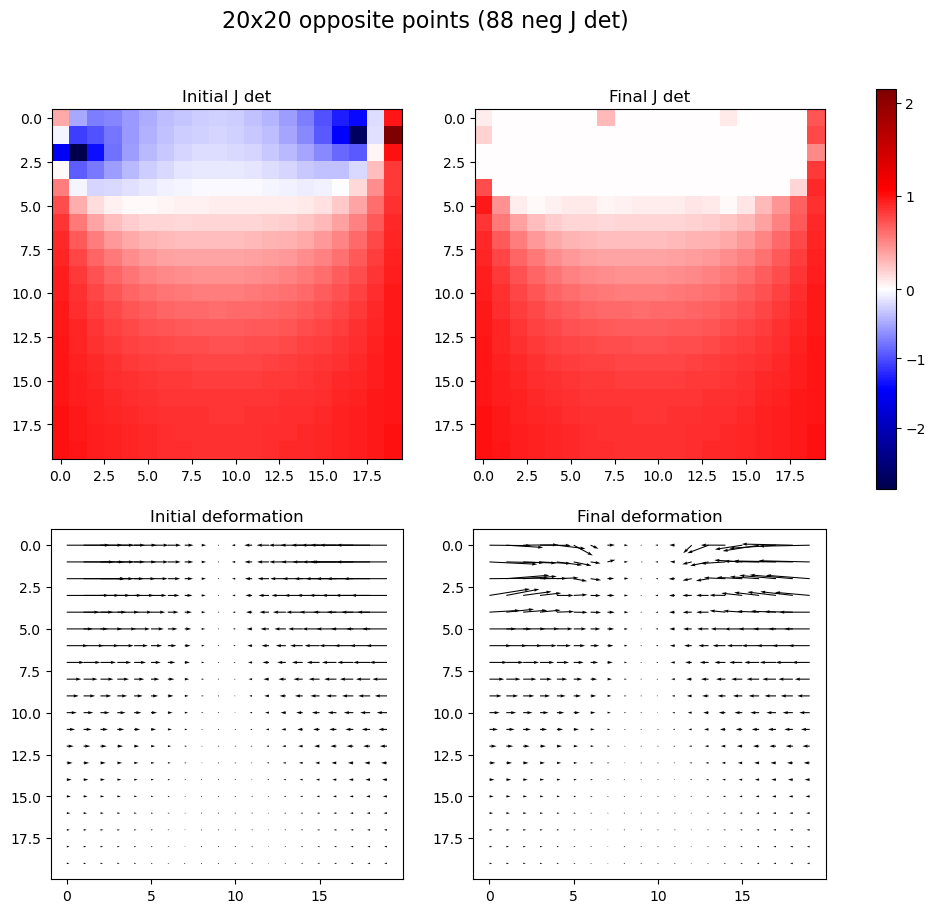

In [42]:
# Data title and where to save the output and results
title = "20x20 opposite points (88 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/088_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 0],
    [0, 2, 18],
])
fsample = np.array([
    [0, 1, 18],
    [0, 2, 0],
])
fixed_sample = np.zeros((1, 20, 20))

deformation_i, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(deformation_i[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, deformation_i, deformation_i, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### 198 neg Jdet

Number of negative Jacobians in initial deformation: 198
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 23.920817194362982
            Iterations: 490
            Function evaluations: 392185
            Gradient evaluations: 489
OP result error: 23.920817194362982
Deviation from initial = 23.920817194362986
Changed number of -ve jacobians from 198 to 0
Time taken for full SLSQP optimisation: 1192.9898734092712s
             x-def                y-def            jacobian          
               min        max       min       max       min       max
initial -17.998500  17.998500  0.000000  0.000000 -2.748975  2.281755
final   -17.950136  18.110496 -3.075552  4.367055  0.010000  1.024475
meshgrid shape for plot: (20, 20)


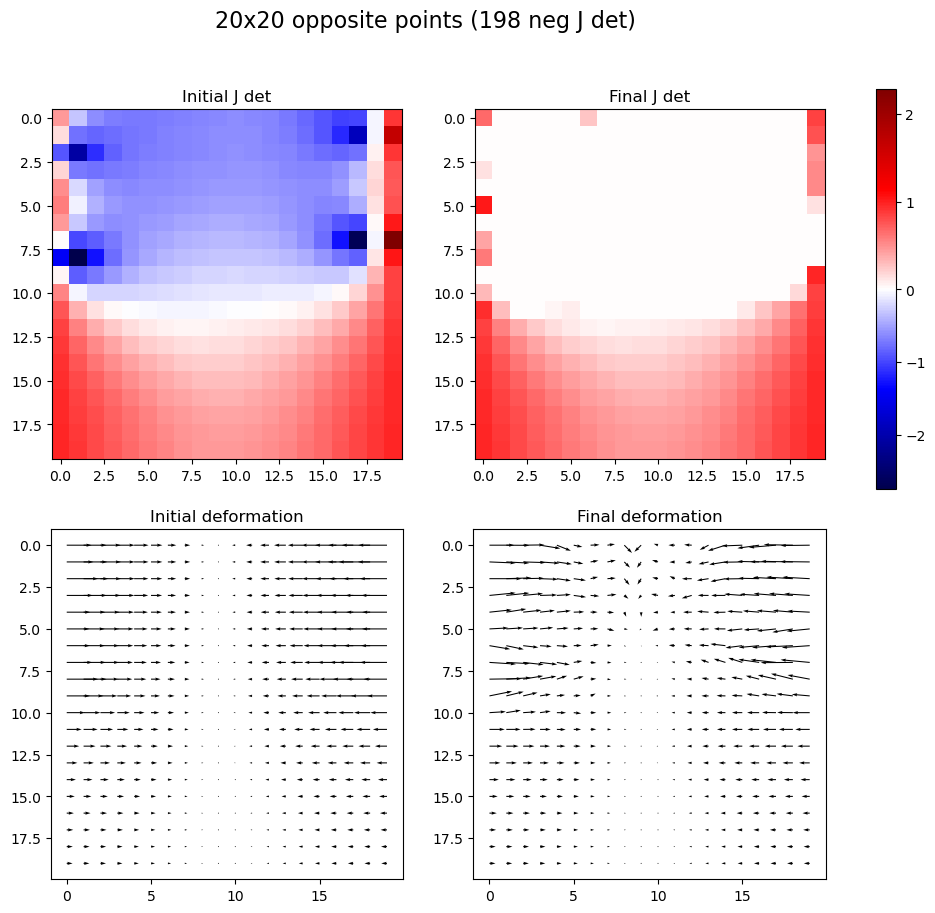

In [50]:
# Data title and where to save the output and results
title = "20x20 opposite points (198 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/198_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 0],
    [0, 2, 18],
    [0, 7, 0],
    [0, 8, 18],
])
fsample = np.array([
    [0, 1, 18],
    [0, 2, 0],
    [0, 7, 18],
    [0, 8, 0],
])
fixed_sample = np.zeros((1, 20, 20))

deformation_i, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(deformation_i[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, deformation_i, deformation_i, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### 334 neg Jdet

Number of negative Jacobians in initial deformation: 334
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 37.71301505968088
            Iterations: 411
            Function evaluations: 329487
            Gradient evaluations: 411
OP result error: 37.71301505968088
Deviation from initial = 37.71301505968088
Changed number of -ve jacobians from 334 to 0
Time taken for full SLSQP optimisation: 1036.371175289154s
            x-def                y-def            jacobian         
              min        max       min       max       min      max
initial -17.99870  17.998700  0.000000  0.000000 -2.465649  2.19053
final   -17.99815  18.319965 -4.024224  5.252338  0.010000  1.13912
meshgrid shape for plot: (20, 20)


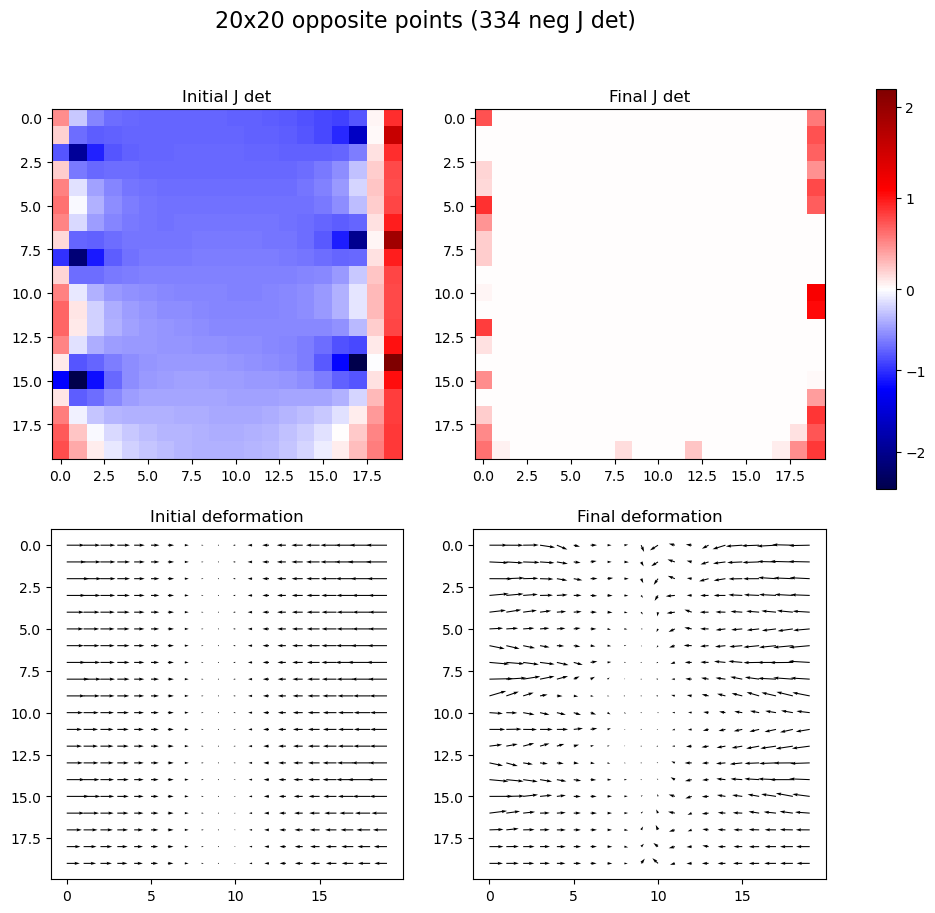

In [51]:
# Data title and where to save the output and results
title = "20x20 opposite points (334 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/334_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 0],
    [0, 2, 18],
    [0, 7, 0],
    [0, 8, 18],
    [0, 14, 0],
    [0, 15, 18],
])
fsample = np.array([
    [0, 1, 18],
    [0, 2, 0],
    [0, 7, 18],
    [0, 8, 0],
    [0, 14, 18],
    [0, 15, 0],
])
fixed_sample = np.zeros((1, 20, 20))

deformation_i, _, _, _, _ = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(deformation_i[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, deformation_i, deformation_i, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### Plot times

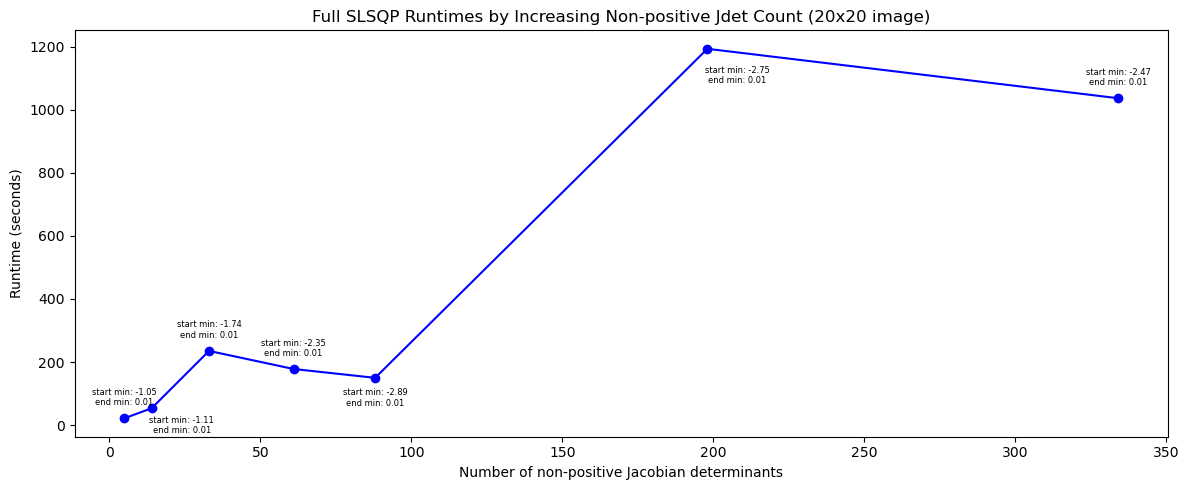

In [ ]:
import matplotlib.pyplot as plt

num_neg_jdets = [5, 14, 33, 61, 88, 198, 334]
time_taken = [21.93301224708557, 53.63300800323486, 235.39268445968628, 178.0353138446808, 150.0301489830017, 1192.9898734092712, 1036.371175289154]
starting_min_jdet = [-1.053231 , -1.11421, -1.737686, -2.351572, -2.890413, -2.748975, -2.465649]  # Initial Jacobian determinants are all zero
end_min_jdet = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]  # Final Jacobian determinants are all zero

# Plot all the times taken
plt.figure(figsize=(12, 5))
plt.plot(num_neg_jdets, time_taken, marker='o', linestyle='-', color='b')
plt.xlabel('Number of non-positive Jacobian determinants')
plt.ylabel('Runtime (seconds)')
plt.title('Full SLSQP Runtimes by Increasing Non-positive Jdet Count (20x20 image)')

# Annotate each point with starting and end min jdet
for i in range(len(num_neg_jdets)):
    x = num_neg_jdets[i]
    y = time_taken[i]
    start_j = starting_min_jdet[i]
    end_j = end_min_jdet[i]
    if x == 14:
        x += 10
        y -= 120
    elif x == 88:
        y -= 130
    elif x == 198:
        x += 10
        y -= 150
    plt.text(x, y + 35, f"start min: {start_j:.2f}\nend min: {end_j:.2f}", 
             ha='center', va='bottom', fontsize=6, color='black')

plt.tight_layout()
plt.savefig('paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/runtime_plot.png', bbox_inches='tight')
plt.show()

### Random DVF

In [43]:
import numpy as np
from scipy.ndimage import zoom


def generate_random_dvf(shape, max_magnitude=5.0, seed=None):
    """
    Generate a random 2D deformation vector field (DVF).
    
    Parameters:
        shape: tuple (3, 1, H, W)
        max_magnitude: float, max displacement in pixels
        seed: int or None, for reproducibility

    Returns:
        np.ndarray of shape (3, 1, H, W)
    """
    if seed is not None:
        np.random.seed(seed)

    C, _, H, W = shape
    assert C == 3, "DVF must have 3 channels (dz, dy, dx)"
    
    # Uniform random displacement in range [-max_magnitude, +max_magnitude]
    dvf = np.random.uniform(-max_magnitude, max_magnitude, size=shape).astype(np.float32)
    return dvf


def scale_dvf_numpy(dvf, new_size):
    """
    Downscale a deformation vector field (DVF).
    dvf: np.ndarray of shape (3, 1, H, W)
    new_size: (new_H, new_W)
    """
    C, _, H, W = dvf.shape
    new_H, new_W = new_size
    scale_y = new_H / H
    scale_x = new_W / W

    dvf_resized = np.zeros((C, 1, new_H, new_W), dtype=dvf.dtype)
    for c in range(C):
        # zoom along spatial dimensions
        dvf_resized[c, 0] = zoom(dvf[c, 0], (scale_y, scale_x), order=1)

    # scale vector magnitudes appropriately
    dvf_resized[2, 0] *= scale_x  # x
    dvf_resized[1, 0] *= scale_y  # y
    #dvf_resized[2, 0] *= (scale_x + scale_y) / 2  # z, if needed

    return dvf_resized

### 130 neg Jdet

Number of negative Jacobians in initial deformation: 130
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.96737224811216
            Iterations: 24
            Function evaluations: 19235
            Gradient evaluations: 24
OP result error: 9.96737224811216
Deviation from initial = 9.967372248112161
Changed number of -ve jacobians from 130 to 0
Time taken for full SLSQP optimisation: 55.032790422439575s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -2.476840  2.489671 -2.445812  2.498588 -5.255103  7.418534
final   -2.662801  2.494880 -2.690530  2.650494  0.010000  6.404523
meshgrid shape for plot: (20, 20)


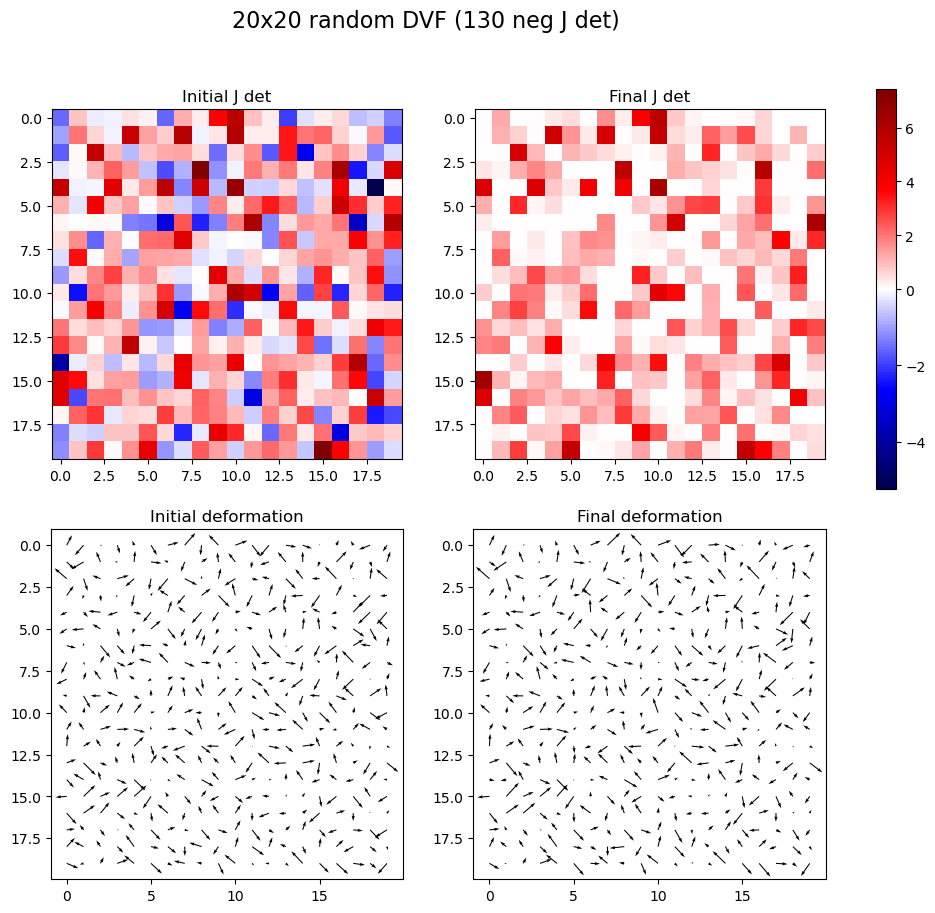

In [44]:
dvf = generate_random_dvf((3, 1, 20, 20), max_magnitude=2.5, seed=42)

# Data title and where to save the output and results
title = "20x20 random DVF (130 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/130_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 0, 0],
])
fsample = np.array([
    [0, 0, 0],
])
fixed_sample = np.zeros((1, 20, 20))

print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(dvf[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, dvf, dvf, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(dvf, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, dvf, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### 205 neg Jdet

Number of negative Jacobians in initial deformation: 205
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 104.42152294960944
            Iterations: 165
            Function evaluations: 132168
            Gradient evaluations: 165
OP result error: 104.42152294960944
Deviation from initial = 104.42152294960944
Changed number of -ve jacobians from 205 to 0
Time taken for full SLSQP optimisation: 402.4148426055908s
             x-def                 y-def              jacobian            
               min        max        min       max         min         max
initial -14.861039  14.938024 -14.674870  14.99153 -164.719699  191.477532
final   -16.393225  16.944948 -16.667133  17.75109    0.010000  123.342161
meshgrid shape for plot: (20, 20)


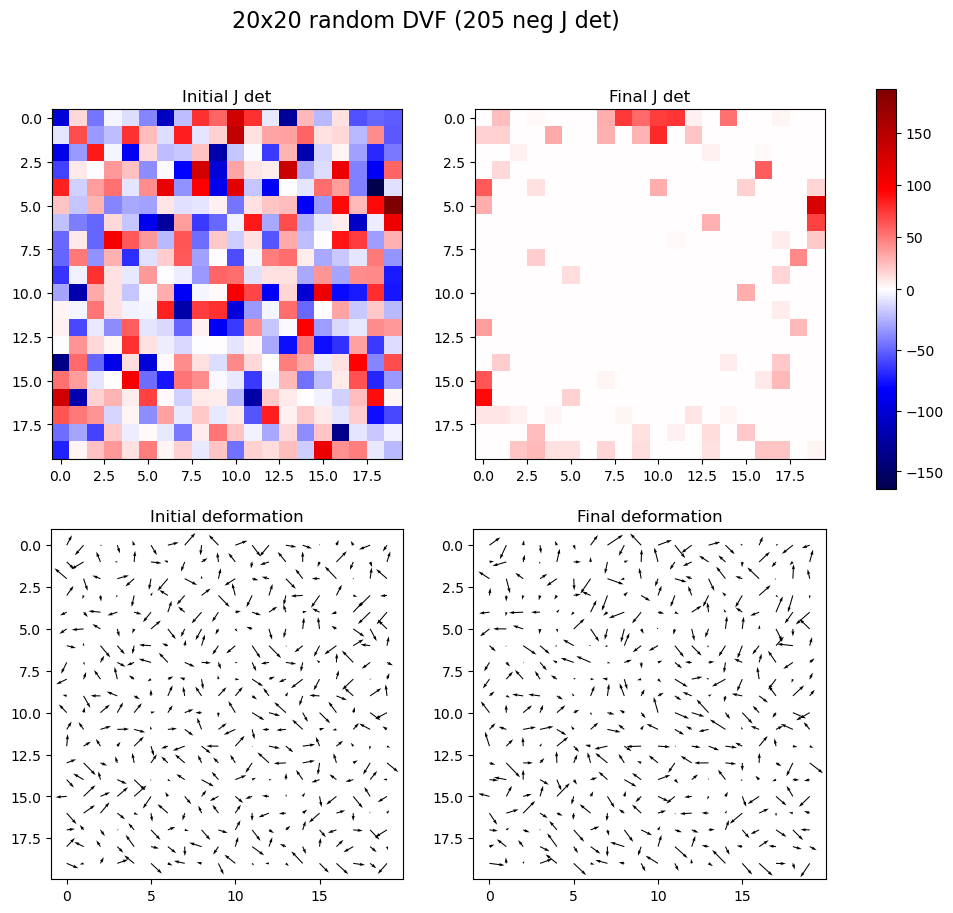

In [45]:
dvf = generate_random_dvf((3, 1, 20, 20), max_magnitude=15.0, seed=42)

# Data title and where to save the output and results
title = "20x20 random DVF (205 neg J det)"
save_path = f"paper_outputs/experiments/full_slsqp/runtime/increasing_neg_jdet_count/205_neg_jdet.npy"

# Sample moving and fixed points
msample = np.array([
    [0, 1, 0],
])
fsample = np.array([
    [0, 1, 18],
])
fixed_sample = np.zeros((1, 20, 20))

print(f"Number of negative Jacobians in initial deformation: {(jacobian_det2D(dvf[1:]) <= 0).sum()}")
#plot_deformations(msample, fsample, dvf, dvf, figsize=(10, 10), title=title, save_path=save_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(dvf, 'SLSQP', save_path=save_path)
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, dvf, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

# Other

#### 1c - 20x40 edges

deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.941606751765476
            Iterations: 17
            Function evaluations: 27230
            Gradient evaluations: 17
OP result error: 2.941606751765476
Deviation from initial = 2.9416067517654794
Changed number of -ve jacobians from 29 to 0
Time taken for full SLSQP optimisation: 105.69216561317444s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -6.999377  4.999555 -4.999602  3.999682 -1.343039  4.142665
final   -7.000041  4.909078 -5.000265  3.845181  0.010000  4.142665
meshgrid shape for plot: (20, 40)


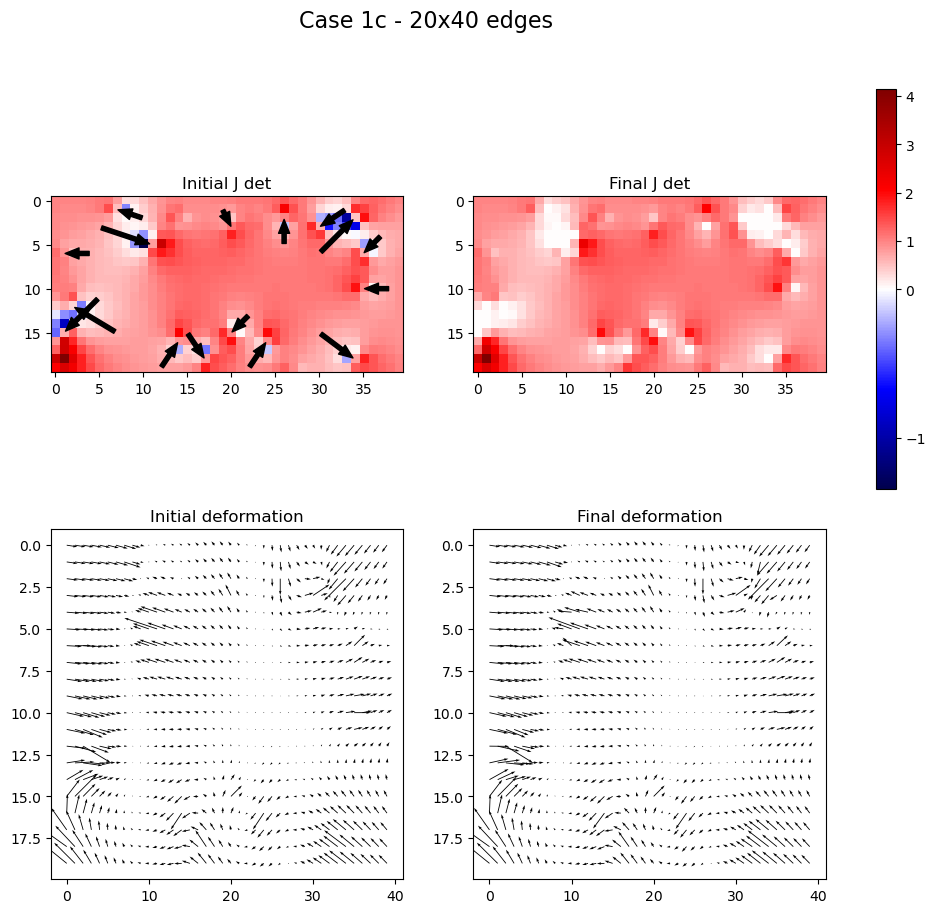

In [32]:
title = "Case 1c - 20x40 edges"
load_path = "experiments/01c_20x40_edges.npy"

save_path = f"paper_outputs/{load_path}"
# Sample moving and fixed points
msample = np.array([
    [0, 2, 10],
    [0, 3, 5],
    [0, 6, 4],
    [0, 11, 5],
    [0, 15, 7],
    [0, 19, 12],
    [0, 15, 15],
    [0, 13, 22],
    [0, 19, 22],
    [0, 19, 27],
    [0, 15, 30],
    [0, 12, 33],
    [0, 10, 38],
    [0, 4, 37],
    [0, 6, 30],
    [0, 1, 33],
    [0, 5, 26],
    [0, 2, 23],
    [0, 1, 19],
    [0, 2, 14],
])
fsample = np.array([
    [0, 1, 7],
    [0, 5, 11],
    [0, 6, 1],
    [0, 15, 1],
    [0, 12, 2],
    [0, 16, 14],
    [0, 18, 17],
    [0, 15, 20],
    [0, 16, 24],
    [0, 19, 27],
    [0, 18, 34],
    [0, 17, 40],
    [0, 10, 35],
    [0, 6, 35],
    [0, 2, 34],
    [0, 3, 30],
    [0, 2, 26],
    [0, 2, 23],
    [0, 3, 20],
    [0, 2, 14],
])
deformation_i = np.load(load_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP')
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

#### 1d - 20x40 crossing points

deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.62014413575945
            Iterations: 180
            Function evaluations: 288231
            Gradient evaluations: 180
OP result error: 16.62014413575945
Deviation from initial = 16.62014413575945
Changed number of -ve jacobians from 158 to 0
Time taken for full SLSQP optimisation: 1105.111577987671s
             x-def                 y-def            jacobian          
               min        max        min       max       min       max
initial -19.976474  19.976474 -10.001746 -9.289016 -3.369923  4.326747
final   -19.960625  19.961938 -13.570774 -7.200949  0.010000  1.734567
meshgrid shape for plot: (20, 40)


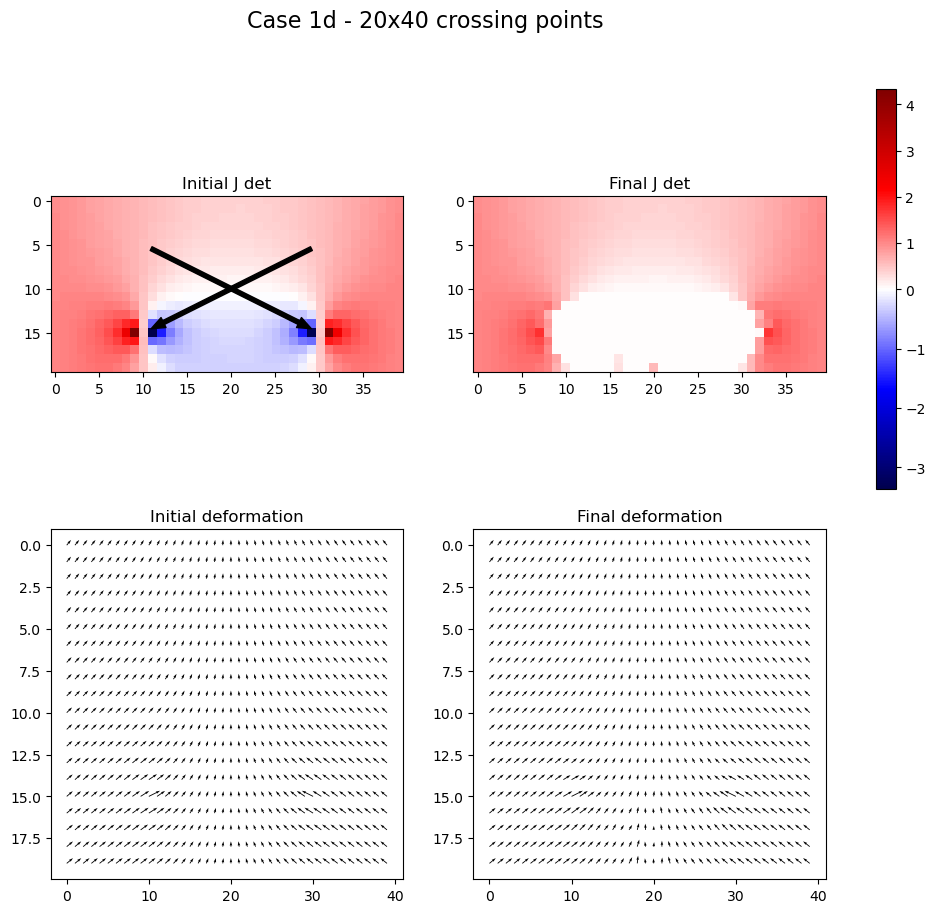

In [33]:
title = "Case 1d - 20x40 crossing points"
load_path = "experiments/01d_20x40_crossing.npy"

save_path = f"paper_outputs/{load_path}"
# Sample moving and fixed points
msample = np.array([
    [0, 5, 10],
    [0, 5, 30],
])
fsample = np.array([
    [0, 15, 30],
    [0, 15, 10],
])
deformation_i = np.load(load_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP')
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

#### 1e - 20x20 spirals

deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 61.161268746762175
            Iterations: 172
            Function evaluations: 137790
            Gradient evaluations: 172
OP result error: 61.161268746762175
Deviation from initial = 61.161268746762175
Changed number of -ve jacobians from 183 to 0
Time taken for full SLSQP optimisation: 415.55945086479187s
             x-def                 y-def              jacobian           
               min        max        min        max        min        max
initial -18.965670  18.783384 -18.141983  17.519009 -30.828441  35.680452
final   -18.965687  18.677361 -18.171107  17.446705   0.010000  25.381986
meshgrid shape for plot: (20, 20)


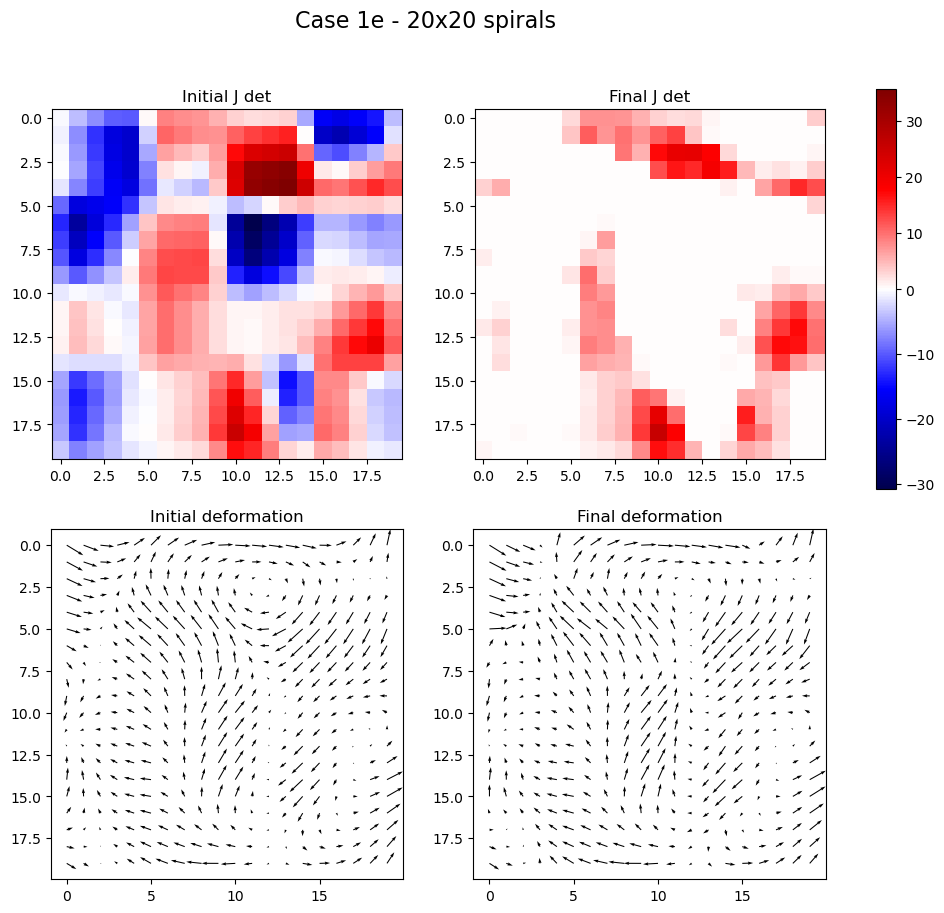

In [34]:
title = "Case 1e - 20x20 spirals"
load_path = "experiments/01e_20x20_random_spirals.npy"

save_path = f"paper_outputs/{load_path}"
# Sample moving and fixed points
msample = np.array([
    [0, 0, 0],
])
fsample = np.array([
    [0, 0, 0],
])
deformation_i = np.load(load_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP')
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

#### 1f - 20x20 random

deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.693004732550625
            Iterations: 114
            Function evaluations: 91371
            Gradient evaluations: 114
OP result error: 13.693004732550625
Deviation from initial = 13.693004732550625
Changed number of -ve jacobians from 149 to 0
Time taken for full SLSQP optimisation: 253.91994976997375s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -2.972208  2.987605 -2.934974  2.998306 -7.531636  9.306843
final   -3.346919  2.992609 -3.315211  3.155549  0.010000  7.994667
meshgrid shape for plot: (20, 20)


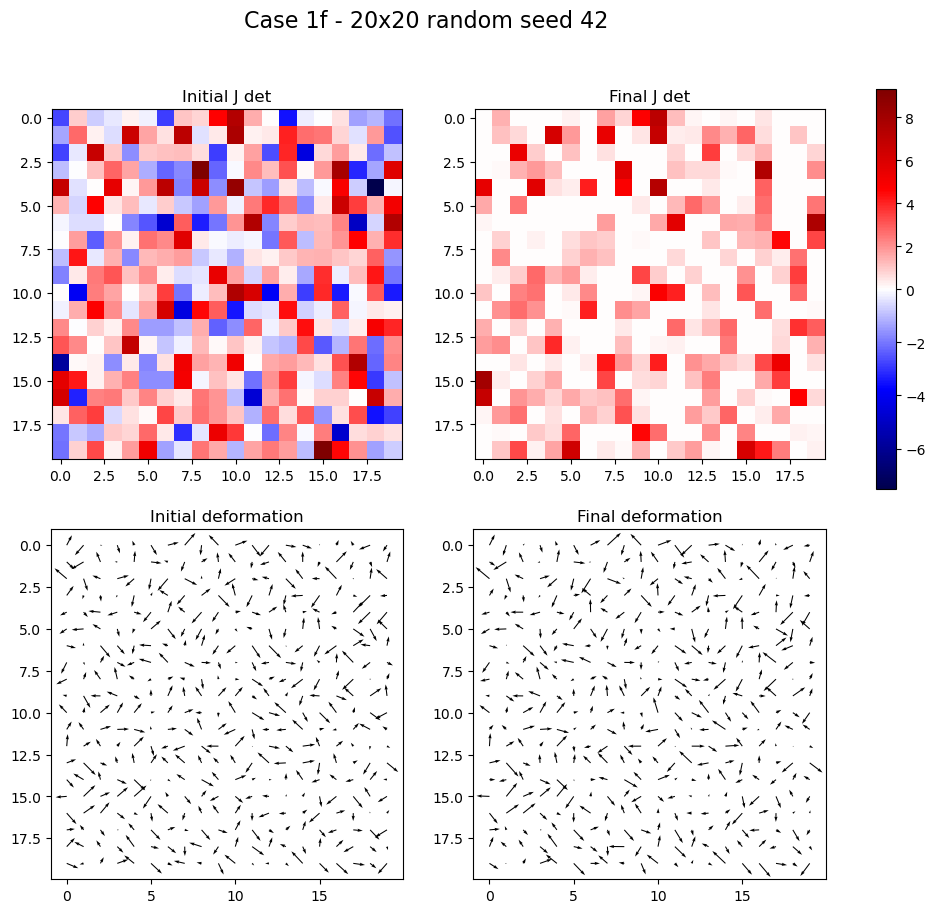

In [35]:
title = "Case 1f - 20x20 random seed 42"
load_path = "experiments/01f_20x20_random_seed_42.npy"

save_path = f"paper_outputs/{load_path}"
# Sample moving and fixed points
msample = np.array([
    [0, 0, 0],
])
fsample = np.array([
    [0, 0, 0],
])
deformation_i = np.load(load_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP')
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### Case 2 - real data

#### 2a - slice 90

deformation_i shape: (3, 1, 64, 91), phi_init shape: (2, 64, 91)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5784180904847518
            Iterations: 13
            Function evaluations: 151449
            Gradient evaluations: 13
OP result error: 0.5784180904847518
Deviation from initial = 0.5784180904847506
Changed number of -ve jacobians from 3 to 0
Time taken for full SLSQP optimisation: 15000.557980537415s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -1.999817  1.999817 -1.999816  1.999816 -0.494795  3.052304
final   -1.999817  1.999817 -1.947919  1.999815  0.010000  2.800622
meshgrid shape for plot: (64, 91)


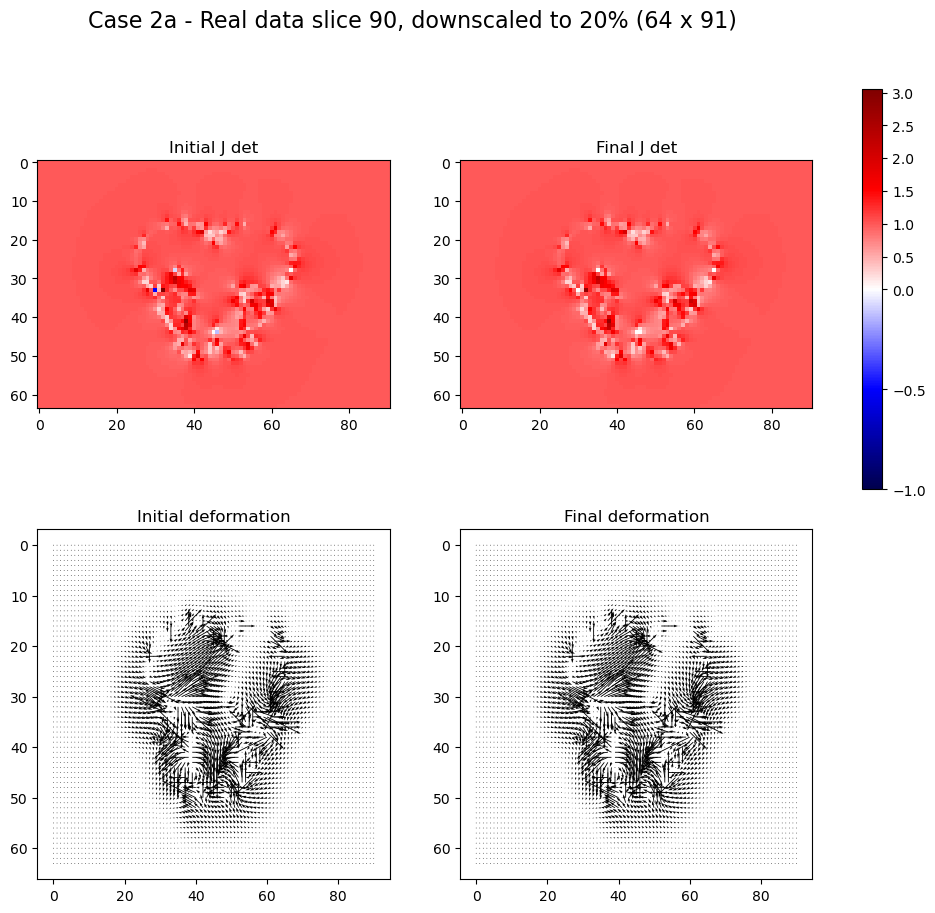

In [37]:
slice_idx = 90
title = f"Case 2a - Real data slice {slice_idx}, downscaled to 20% (64 x 91)"
load_path = f"experiments/02a_64x91_slice{slice_idx}.npy"

save_path = f"paper_outputs/{load_path}"
# Sample moving and fixed points
msample = np.array([
    [0, 0, 0],
])
fsample = np.array([
    [0, 0, 0],
])
deformation_i = np.load(load_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP')
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

#### 2b - slice 200

deformation_i shape: (3, 1, 64, 91), phi_init shape: (2, 64, 91)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.25061248275445125
            Iterations: 17
            Function evaluations: 198048
            Gradient evaluations: 17
OP result error: 0.25061248275445125
Deviation from initial = 0.2506124827544506
Changed number of -ve jacobians from 4 to 0
Time taken for full SLSQP optimisation: 19411.678229808807s
            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -1.999821  1.999821 -2.000153  3.000230 -0.147787  2.999942
final   -1.999821  2.000912 -2.000153  2.867259  0.010000  2.999942
meshgrid shape for plot: (64, 91)


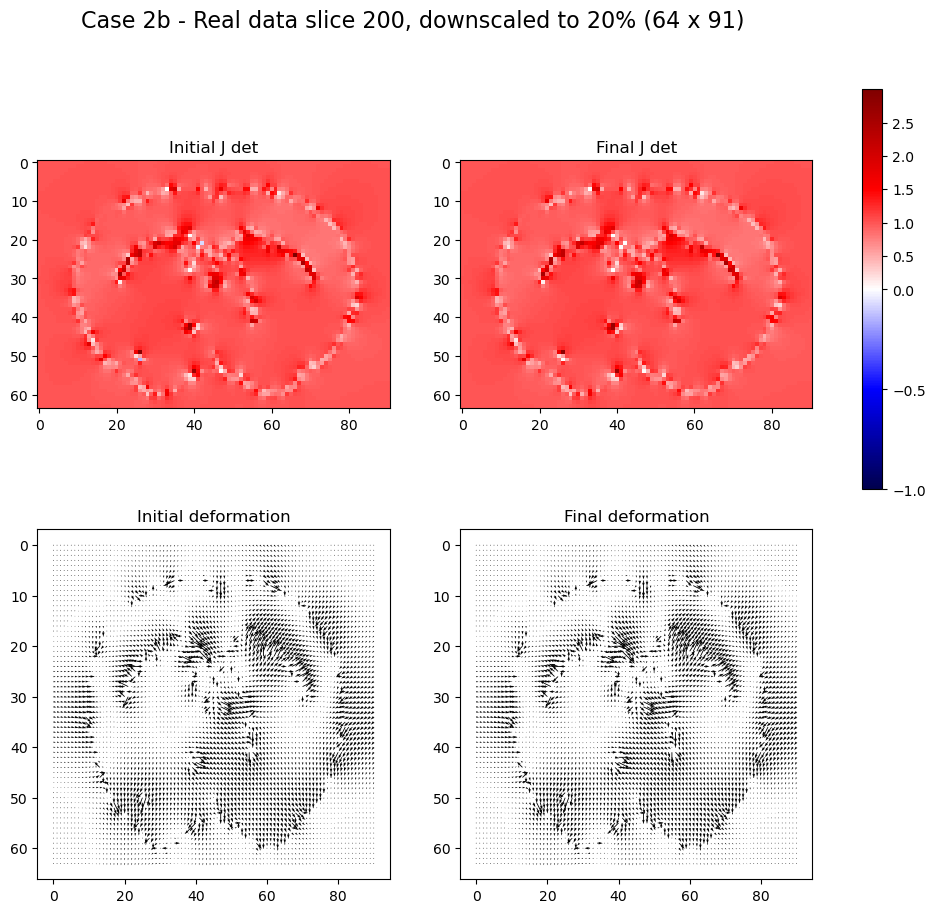

In [11]:
slice_idx = 200
title = f"Case 2b - Real data slice {slice_idx}, downscaled to 20% (64 x 91)"
load_path = f"experiments/02b_64x91_slice{slice_idx}.npy"

save_path = f"paper_outputs/{load_path}"
# Sample moving and fixed points
msample = np.array([
    [0, 0, 0],
])
fsample = np.array([
    [0, 0, 0],
])
deformation_i = np.load(load_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP')
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

#### 2c - slice 350

In [ ]:
slice_idx = 350
title = f"Case 2c - Real data slice {slice_idx}, downscaled to 20% (64 x 91)"
load_path = f"experiments/02c_64x91_slice{slice_idx}.npy"

save_path = f"paper_outputs/{load_path}"
# Sample moving and fixed points
msample = np.array([
    [0, 0, 0],
])
fsample = np.array([
    [0, 0, 0],
])
deformation_i = np.load(load_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP')
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

deformation_i shape: (3, 1, 64, 91), phi_init shape: (2, 64, 91)


#### 2d - slice 500

In [ ]:
slice_idx = 500
title = f"Case 2d - Real data slice {slice_idx}, downscaled to 20% (64 x 91)"
load_path = f"experiments/02d_64x91_slice{slice_idx}.npy"

save_path = f"paper_outputs/{load_path}"
# Sample moving and fixed points
msample = np.array([
    [0, 0, 0],
])
fsample = np.array([
    [0, 0, 0],
])
deformation_i = np.load(load_path)

##############################################################################################################

phi_corrected, _ = full_slsqp(deformation_i, 'SLSQP')
np.save(save_path, phi_corrected)
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10, 10), title=title, save_path=save_path)

### Case 3 - batches of random DVFs

In [9]:
import numpy as np
from scipy.ndimage import zoom


def generate_random_dvf(shape, max_magnitude=5.0, seed=None):
    """
    Generate a random 2D deformation vector field (DVF).
    
    Parameters:
        shape: tuple (3, 1, H, W)
        max_magnitude: float, max displacement in pixels
        seed: int or None, for reproducibility

    Returns:
        np.ndarray of shape (3, 1, H, W)
    """
    if seed is not None:
        np.random.seed(seed)

    C, _, H, W = shape
    assert C == 3, "DVF must have 3 channels (dz, dy, dx)"
    
    # Uniform random displacement in range [-max_magnitude, +max_magnitude]
    dvf = np.random.uniform(-max_magnitude, max_magnitude, size=shape).astype(np.float32)
    return dvf


def scale_dvf_numpy(dvf, new_size):
    """
    Downscale a deformation vector field (DVF).
    dvf: np.ndarray of shape (3, 1, H, W)
    new_size: (new_H, new_W)
    """
    C, _, H, W = dvf.shape
    new_H, new_W = new_size
    scale_y = new_H / H
    scale_x = new_W / W

    dvf_resized = np.zeros((C, 1, new_H, new_W), dtype=dvf.dtype)
    for c in range(C):
        # zoom along spatial dimensions
        dvf_resized[c, 0] = zoom(dvf[c, 0], (scale_y, scale_x), order=1)

    # scale vector magnitudes appropriately
    dvf_resized[2, 0] *= scale_x  # x
    dvf_resized[1, 0] *= scale_y  # y
    #dvf_resized[2, 0] *= (scale_x + scale_y) / 2  # z, if needed

    return dvf_resized

In [ ]:
# Start with an initial DVF
resolution = (10, 10)  # H, W
num_samples = 100

# Record data
start_negJ = []
end_negJ = []
time_taken = []
errors = []
min_jdet = []

dvf_shape = (3, 1, resolution[0], resolution[1])
for i in tqdm(range(num_samples)):
    # Generate initial random DVF
    dvf = generate_random_dvf(dvf_shape, max_magnitude=5.0)
    # Count negative Jacobians at the start
    dvf_jac = jacobian.sitk_jacobian_determinant(dvf)
    dvf_num_neg_jac = (dvf_jac <= 0).sum()
    start_negJ.append(dvf_num_neg_jac)
    # Run SLSQP on the DVF and record times
    start_time = time.time()
    phi_corrected, _ = full_slsqp(dvf, 'SLSQP')
    end_time = time.time()
    time_taken.append(end_time - start_time)
    
    # Record the final number of negative Jacobians
    dvf_final_jac = jacobian_det2D(phi_corrected)
    dvf_final_num_neg_jac = (dvf_final_jac <= 0).sum()
    end_negJ.append(dvf_final_num_neg_jac)
    
    # Record the minimum Jacobian determinant
    min_jdet.append(np.min(dvf_final_jac))
    # Record the error
    error = np.linalg.norm(phi_corrected - dvf)
    errors.append(error)
    
# Save stats
np.save("paper_outputs/experiments/random_runs/10/01_start_negativeJ.npy", start_negJ)
np.save("paper_outputs/experiments/random_runs/10/02_end_negativeJ.npy", end_negJ)
np.save("paper_outputs/experiments/random_runs/10/03_runtimes.npy", time_taken)
np.save("paper_outputs/experiments/random_runs/10/04_errors.npy", errors)
np.save("paper_outputs/experiments/random_runs/10/05_min_jacobian_determinants.npy", min_jdet)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(start_negJ, label='Start Negative J', marker='o')
plt.plot(end_negJ, label='End Negative J', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Number of Negative Jacobians')
plt.title('Negative Jacobians Before and After SLSQP')
plt.legend()
plt.grid()
plt.savefig("paper_outputs/experiments/random_runs/10/negative_jacobians_plot.png")
plt.show()

# Plot the runtimes
plt.figure(figsize=(10, 5))
plt.plot(time_taken, label='Runtime', marker='o', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of SLSQP for Each Sample')
plt.legend()
plt.grid()
plt.savefig("paper_outputs/experiments/random_runs/10/runtime_plot.png")
plt.show()

# Plot the errors
plt.figure(figsize=(10, 5))
plt.plot(errors, label='Error', marker='o', color='green')
plt.xlabel('Sample Index')
plt.ylabel('Error (L2 norm)')
plt.title('Error Between Initial and Corrected DVF')
plt.legend()
plt.grid()
plt.savefig("paper_outputs/experiments/random_runs/10/error_plot.png")
plt.show()

# Plot the minimum Jacobian determinants
plt.figure(figsize=(10, 5))
plt.plot(min_jdet, label='Min Jacobian Det', marker='o', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Minimum Jacobian Determinant')
plt.title('Minimum Jacobian Determinant After SLSQP')
plt.legend()
plt.grid()
plt.savefig("paper_outputs/experiments/random_runs/10/min_jacobian_determinant_plot.png")
plt.show()

# Print summary statistics
print(f"Total samples: {num_samples}")
print(f"Average runtime: {np.mean(time_taken):.4f} seconds")
print(f"Average start negative Jacobians: {np.mean(start_negJ):.2f}")
print(f"Average end negative Jacobians: {np.mean(end_negJ):.2f}")
print(f"Average error: {np.mean(errors):.4f}")
print(f"Average minimum Jacobian determinant: {np.mean(min_jdet):.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  1%|          | 1/100 [00:24<40:12, 24.37s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.326107186033056
            Iterations: 43
            Function evaluations: 8644
            Gradient evaluations: 43
OP result error: 13.326107186033056
Deviation from initial = 13.326107186033056
Changed number of -ve jacobians from 40 to 0
Time taken for full SLSQP optimisation: 24.361843585968018s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  2%|▏         | 2/100 [00:55<46:24, 28.41s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.180860179249132
            Iterations: 56
            Function evaluations: 11260
            Gradient evaluations: 56
OP result error: 15.180860179249132
Deviation from initial = 15.180860179249132
Changed number of -ve jacobians from 52 to 0
Time taken for full SLSQP optimisation: 31.234320878982544s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  3%|▎         | 3/100 [01:26<48:04, 29.73s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.835768002456295
            Iterations: 56
            Function evaluations: 11258
            Gradient evaluations: 56
OP result error: 14.835768002456295
Deviation from initial = 14.835768002456295
Changed number of -ve jacobians from 41 to 0
Time taken for full SLSQP optimisation: 31.303826570510864s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  4%|▍         | 4/100 [01:57<47:54, 29.94s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.476480267564035
            Iterations: 53
            Function evaluations: 10658
            Gradient evaluations: 53
OP result error: 12.476480267564035
Deviation from initial = 12.476480267564037
Changed number of -ve jacobians from 37 to 0
Time taken for full SLSQP optimisation: 30.242796182632446s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  5%|▌         | 5/100 [02:21<43:55, 27.74s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.528314656525641
            Iterations: 42
            Function evaluations: 8442
            Gradient evaluations: 42
OP result error: 14.528314656525641
Deviation from initial = 14.528314656525641
Changed number of -ve jacobians from 40 to 0
Time taken for full SLSQP optimisation: 23.830679178237915s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  6%|▌         | 6/100 [02:42<40:18, 25.73s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.40226120572707
            Iterations: 39
            Function evaluations: 7840
            Gradient evaluations: 39
OP result error: 14.40226120572707
Deviation from initial = 14.40226120572707
Changed number of -ve jacobians from 54 to 0
Time taken for full SLSQP optimisation: 21.825700521469116s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  7%|▋         | 7/100 [03:07<39:32, 25.51s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.313747067116227
            Iterations: 45
            Function evaluations: 9046
            Gradient evaluations: 45
OP result error: 14.313747067116227
Deviation from initial = 14.313747067116225
Changed number of -ve jacobians from 49 to 0
Time taken for full SLSQP optimisation: 25.040672063827515s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  8%|▊         | 8/100 [03:33<39:18, 25.64s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.259478188177603
            Iterations: 47
            Function evaluations: 9448
            Gradient evaluations: 47
OP result error: 12.259478188177603
Deviation from initial = 12.259478188177603
Changed number of -ve jacobians from 41 to 0
Time taken for full SLSQP optimisation: 25.912949562072754s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


  9%|▉         | 9/100 [03:56<37:19, 24.61s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.682029773883258
            Iterations: 40
            Function evaluations: 8041
            Gradient evaluations: 40
OP result error: 14.682029773883258
Deviation from initial = 14.682029773883258
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 22.334588050842285s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 10%|█         | 10/100 [04:20<36:44, 24.49s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.228417831060572
            Iterations: 43
            Function evaluations: 8644
            Gradient evaluations: 43
OP result error: 12.228417831060572
Deviation from initial = 12.228417831060575
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 24.22507643699646s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 11%|█         | 11/100 [04:42<35:12, 23.73s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.2940882166685
            Iterations: 38
            Function evaluations: 7639
            Gradient evaluations: 38
OP result error: 13.2940882166685
Deviation from initial = 13.2940882166685
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 22.01114058494568s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 12%|█▏        | 12/100 [04:59<31:42, 21.62s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.437259986333554
            Iterations: 29
            Function evaluations: 5830
            Gradient evaluations: 29
OP result error: 11.437259986333554
Deviation from initial = 11.437259986333556
Changed number of -ve jacobians from 41 to 0
Time taken for full SLSQP optimisation: 16.792511701583862s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 13%|█▎        | 13/100 [05:26<33:46, 23.29s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.379331641932401
            Iterations: 48
            Function evaluations: 9651
            Gradient evaluations: 48
OP result error: 14.379331641932401
Deviation from initial = 14.379331641932401
Changed number of -ve jacobians from 41 to 0
Time taken for full SLSQP optimisation: 27.11308264732361s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 14%|█▍        | 14/100 [05:59<37:43, 26.32s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.582735620984609
            Iterations: 57
            Function evaluations: 11458
            Gradient evaluations: 57
OP result error: 15.582735620984609
Deviation from initial = 15.582735620984609
Changed number of -ve jacobians from 52 to 0
Time taken for full SLSQP optimisation: 33.32979989051819s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 15%|█▌        | 15/100 [06:26<37:30, 26.47s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 17.08518279601119
            Iterations: 46
            Function evaluations: 9247
            Gradient evaluations: 46
OP result error: 17.08518279601119
Deviation from initial = 17.08518279601119
Changed number of -ve jacobians from 51 to 0
Time taken for full SLSQP optimisation: 26.81349015235901s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 16%|█▌        | 16/100 [07:07<43:04, 30.77s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.658364220461653
            Iterations: 71
            Function evaluations: 14301
            Gradient evaluations: 71
OP result error: 14.658364220461653
Deviation from initial = 14.658364220461655
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 40.7355432510376s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 17%|█▋        | 17/100 [07:29<38:54, 28.13s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.372342642860735
            Iterations: 39
            Function evaluations: 7840
            Gradient evaluations: 39
OP result error: 15.372342642860735
Deviation from initial = 15.372342642860737
Changed number of -ve jacobians from 46 to 0
Time taken for full SLSQP optimisation: 21.98435401916504s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 18%|█▊        | 18/100 [07:52<36:26, 26.66s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.45881913572683
            Iterations: 41
            Function evaluations: 8242
            Gradient evaluations: 41
OP result error: 14.45881913572683
Deviation from initial = 14.458819135726833
Changed number of -ve jacobians from 41 to 0
Time taken for full SLSQP optimisation: 23.24068784713745s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 19%|█▉        | 19/100 [08:14<34:11, 25.32s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.966624450573843
            Iterations: 40
            Function evaluations: 8041
            Gradient evaluations: 40
OP result error: 14.966624450573843
Deviation from initial = 14.966624450573843
Changed number of -ve jacobians from 40 to 0
Time taken for full SLSQP optimisation: 22.193400859832764s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 20%|██        | 20/100 [08:44<35:32, 26.66s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.24782782355996
            Iterations: 58
            Function evaluations: 11658
            Gradient evaluations: 58
OP result error: 15.24782782355996
Deviation from initial = 15.24782782355996
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 29.774923086166382s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 21%|██        | 21/100 [09:06<33:12, 25.22s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.960434715311088
            Iterations: 46
            Function evaluations: 9247
            Gradient evaluations: 46
OP result error: 14.960434715311088
Deviation from initial = 14.960434715311088
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 21.85379385948181s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 22%|██▏       | 22/100 [10:06<46:24, 35.70s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.522121298575652
            Iterations: 125
            Function evaluations: 25183
            Gradient evaluations: 125
OP result error: 14.522121298575652
Deviation from initial = 14.522121298575652
Changed number of -ve jacobians from 48 to 0
Time taken for full SLSQP optimisation: 60.13965463638306s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 23%|██▎       | 23/100 [10:32<42:17, 32.95s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.652978187804697
            Iterations: 47
            Function evaluations: 9448
            Gradient evaluations: 47
OP result error: 13.652978187804697
Deviation from initial = 13.652978187804697
Changed number of -ve jacobians from 48 to 0
Time taken for full SLSQP optimisation: 26.538113117218018s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 24%|██▍       | 24/100 [11:02<40:34, 32.03s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.405776411807482
            Iterations: 54
            Function evaluations: 10855
            Gradient evaluations: 54
OP result error: 13.405776411807482
Deviation from initial = 13.405776411807482
Changed number of -ve jacobians from 50 to 0
Time taken for full SLSQP optimisation: 29.8636794090271s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 25%|██▌       | 25/100 [11:29<37:52, 30.30s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.278775149197148
            Iterations: 47
            Function evaluations: 9448
            Gradient evaluations: 47
OP result error: 13.278775149197148
Deviation from initial = 13.278775149197148
Changed number of -ve jacobians from 41 to 0
Time taken for full SLSQP optimisation: 26.262459754943848s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 26%|██▌       | 26/100 [11:52<34:54, 28.31s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.301774929826498
            Iterations: 43
            Function evaluations: 8643
            Gradient evaluations: 43
OP result error: 13.301774929826498
Deviation from initial = 13.301774929826497
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 23.646063327789307s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 27%|██▋       | 27/100 [12:16<32:52, 27.02s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.489585378838983
            Iterations: 43
            Function evaluations: 8644
            Gradient evaluations: 43
OP result error: 15.489585378838983
Deviation from initial = 15.489585378838983
Changed number of -ve jacobians from 50 to 0
Time taken for full SLSQP optimisation: 24.022236347198486s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 28%|██▊       | 28/100 [12:38<30:26, 25.36s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.151007067711395
            Iterations: 39
            Function evaluations: 7839
            Gradient evaluations: 39
OP result error: 14.151007067711395
Deviation from initial = 14.151007067711395
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 21.484391689300537s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 29%|██▉       | 29/100 [12:59<28:24, 24.01s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.723968433590988
            Iterations: 35
            Function evaluations: 7036
            Gradient evaluations: 35
OP result error: 12.723968433590988
Deviation from initial = 12.723968433590988
Changed number of -ve jacobians from 37 to 0
Time taken for full SLSQP optimisation: 20.849440097808838s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 30%|███       | 30/100 [13:26<29:08, 24.98s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.928312223983578
            Iterations: 45
            Function evaluations: 9046
            Gradient evaluations: 45
OP result error: 15.928312223983578
Deviation from initial = 15.928312223983578
Changed number of -ve jacobians from 48 to 0
Time taken for full SLSQP optimisation: 27.238736867904663s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 31%|███       | 31/100 [13:55<30:17, 26.35s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.270922627011217
            Iterations: 51
            Function evaluations: 10252
            Gradient evaluations: 51
OP result error: 15.270922627011217
Deviation from initial = 15.270922627011217
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 29.52134084701538s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 32%|███▏      | 32/100 [14:19<29:05, 25.66s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.113874197840781
            Iterations: 42
            Function evaluations: 8443
            Gradient evaluations: 42
OP result error: 13.113874197840781
Deviation from initial = 13.113874197840781
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 24.072287797927856s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 33%|███▎      | 33/100 [14:46<28:47, 25.78s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.621879801647506
            Iterations: 45
            Function evaluations: 9046
            Gradient evaluations: 45
OP result error: 16.621879801647506
Deviation from initial = 16.621879801647506
Changed number of -ve jacobians from 46 to 0
Time taken for full SLSQP optimisation: 26.05219030380249s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 34%|███▍      | 34/100 [15:11<28:12, 25.65s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.072753575688498
            Iterations: 44
            Function evaluations: 8845
            Gradient evaluations: 44
OP result error: 14.072753575688498
Deviation from initial = 14.072753575688498
Changed number of -ve jacobians from 44 to 0
Time taken for full SLSQP optimisation: 25.32540988922119s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 35%|███▌      | 35/100 [15:46<30:47, 28.42s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.186823291239094
            Iterations: 60
            Function evaluations: 12061
            Gradient evaluations: 60
OP result error: 16.186823291239094
Deviation from initial = 16.186823291239094
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 34.889583110809326s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 36%|███▌      | 36/100 [16:08<28:16, 26.51s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.99022243536515
            Iterations: 38
            Function evaluations: 7638
            Gradient evaluations: 38
OP result error: 12.99022243536515
Deviation from initial = 12.99022243536515
Changed number of -ve jacobians from 46 to 0
Time taken for full SLSQP optimisation: 22.049063444137573s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 37%|███▋      | 37/100 [16:30<26:21, 25.10s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.562398069198881
            Iterations: 37
            Function evaluations: 7437
            Gradient evaluations: 37
OP result error: 12.562398069198881
Deviation from initial = 12.562398069198881
Changed number of -ve jacobians from 39 to 0
Time taken for full SLSQP optimisation: 21.79833221435547s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 38%|███▊      | 38/100 [16:57<26:38, 25.78s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.612502476749112
            Iterations: 46
            Function evaluations: 9247
            Gradient evaluations: 46
OP result error: 12.612502476749112
Deviation from initial = 12.612502476749114
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 27.376513719558716s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 39%|███▉      | 39/100 [17:18<24:48, 24.41s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.023834647255681
            Iterations: 37
            Function evaluations: 7437
            Gradient evaluations: 37
OP result error: 14.023834647255681
Deviation from initial = 14.023834647255681
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 21.182467460632324s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 40%|████      | 40/100 [17:34<21:50, 21.85s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.213577443286592
            Iterations: 27
            Function evaluations: 5428
            Gradient evaluations: 27
OP result error: 11.213577443286592
Deviation from initial = 11.213577443286592
Changed number of -ve jacobians from 46 to 0
Time taken for full SLSQP optimisation: 15.874567985534668s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 41%|████      | 41/100 [18:21<28:52, 29.37s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.094738766710087
            Iterations: 81
            Function evaluations: 16316
            Gradient evaluations: 81
OP result error: 14.094738766710087
Deviation from initial = 14.094738766710087
Changed number of -ve jacobians from 38 to 0
Time taken for full SLSQP optimisation: 46.91520285606384s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 42%|████▏     | 42/100 [18:51<28:39, 29.65s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.903925799583122
            Iterations: 53
            Function evaluations: 10654
            Gradient evaluations: 53
OP result error: 15.903925799583122
Deviation from initial = 15.903925799583122
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 30.284183502197266s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 43%|████▎     | 43/100 [19:20<27:53, 29.36s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.409418856849666
            Iterations: 50
            Function evaluations: 10052
            Gradient evaluations: 50
OP result error: 13.409418856849666
Deviation from initial = 13.409418856849664
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 28.686670541763306s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 44%|████▍     | 44/100 [19:45<26:02, 27.91s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.268239902376525
            Iterations: 42
            Function evaluations: 8443
            Gradient evaluations: 42
OP result error: 11.268239902376525
Deviation from initial = 11.268239902376527
Changed number of -ve jacobians from 38 to 0
Time taken for full SLSQP optimisation: 24.513029098510742s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 45%|████▌     | 45/100 [20:24<28:43, 31.33s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.29529661391723
            Iterations: 71
            Function evaluations: 14286
            Gradient evaluations: 71
OP result error: 14.29529661391723
Deviation from initial = 14.29529661391723
Changed number of -ve jacobians from 40 to 0
Time taken for full SLSQP optimisation: 39.30829048156738s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 46%|████▌     | 46/100 [20:51<26:56, 29.94s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.58649721176763
            Iterations: 47
            Function evaluations: 9448
            Gradient evaluations: 47
OP result error: 14.58649721176763
Deviation from initial = 14.586497211767632
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 26.687663078308105s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 47%|████▋     | 47/100 [21:13<24:26, 27.66s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.346074757594888
            Iterations: 38
            Function evaluations: 7639
            Gradient evaluations: 38
OP result error: 12.346074757594888
Deviation from initial = 12.346074757594888
Changed number of -ve jacobians from 46 to 0
Time taken for full SLSQP optimisation: 22.34081721305847s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 48%|████▊     | 48/100 [21:45<25:06, 28.97s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.531055353650792
            Iterations: 52
            Function evaluations: 10453
            Gradient evaluations: 52
OP result error: 16.531055353650792
Deviation from initial = 16.531055353650792
Changed number of -ve jacobians from 50 to 0
Time taken for full SLSQP optimisation: 32.01483726501465s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 49%|████▉     | 49/100 [22:13<24:21, 28.66s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.8359559558026
            Iterations: 48
            Function evaluations: 9649
            Gradient evaluations: 48
OP result error: 13.8359559558026
Deviation from initial = 13.8359559558026
Changed number of -ve jacobians from 44 to 0
Time taken for full SLSQP optimisation: 27.928229808807373s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 50%|█████     | 50/100 [22:48<25:37, 30.76s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.534801425665718
            Iterations: 63
            Function evaluations: 12664
            Gradient evaluations: 63
OP result error: 14.534801425665718
Deviation from initial = 14.53480142566572
Changed number of -ve jacobians from 46 to 0
Time taken for full SLSQP optimisation: 35.64097881317139s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 51%|█████     | 51/100 [23:05<21:36, 26.46s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.966596283384156
            Iterations: 29
            Function evaluations: 5829
            Gradient evaluations: 29
OP result error: 12.966596283384156
Deviation from initial = 12.966596283384156
Changed number of -ve jacobians from 50 to 0
Time taken for full SLSQP optimisation: 16.42476511001587s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 52%|█████▏    | 52/100 [23:35<22:00, 27.51s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.723139290125403
            Iterations: 54
            Function evaluations: 10854
            Gradient evaluations: 54
OP result error: 12.723139290125403
Deviation from initial = 12.723139290125403
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 29.94587516784668s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 53%|█████▎    | 53/100 [24:09<23:10, 29.59s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.810843053717097
            Iterations: 60
            Function evaluations: 12061
            Gradient evaluations: 60
OP result error: 16.810843053717097
Deviation from initial = 16.8108430537171
Changed number of -ve jacobians from 50 to 0
Time taken for full SLSQP optimisation: 34.4308819770813s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 54%|█████▍    | 54/100 [24:31<20:50, 27.18s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.856971963821508
            Iterations: 37
            Function evaluations: 7438
            Gradient evaluations: 37
OP result error: 13.856971963821508
Deviation from initial = 13.856971963821508
Changed number of -ve jacobians from 41 to 0
Time taken for full SLSQP optimisation: 21.56554102897644s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 55%|█████▌    | 55/100 [25:18<24:51, 33.13s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.706065320802983
            Iterations: 80
            Function evaluations: 16118
            Gradient evaluations: 80
OP result error: 13.706065320802983
Deviation from initial = 13.706065320802983
Changed number of -ve jacobians from 52 to 0
Time taken for full SLSQP optimisation: 47.01854395866394s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 56%|█████▌    | 56/100 [25:42<22:21, 30.49s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.19379964694811
            Iterations: 40
            Function evaluations: 8041
            Gradient evaluations: 40
OP result error: 13.19379964694811
Deviation from initial = 13.193799646948108
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 24.300155878067017s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 57%|█████▋    | 57/100 [26:07<20:32, 28.66s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.662264231055417
            Iterations: 39
            Function evaluations: 7840
            Gradient evaluations: 39
OP result error: 12.662264231055417
Deviation from initial = 12.662264231055417
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 24.393614292144775s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 58%|█████▊    | 58/100 [26:40<21:08, 30.20s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.56315192860794
            Iterations: 55
            Function evaluations: 11056
            Gradient evaluations: 55
OP result error: 15.56315192860794
Deviation from initial = 15.563151928607939
Changed number of -ve jacobians from 49 to 0
Time taken for full SLSQP optimisation: 33.79419016838074s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 59%|█████▉    | 59/100 [27:02<18:54, 27.68s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.583171748865611
            Iterations: 35
            Function evaluations: 7036
            Gradient evaluations: 35
OP result error: 12.583171748865611
Deviation from initial = 12.583171748865611
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 21.794466495513916s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 60%|██████    | 60/100 [27:35<19:24, 29.12s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.394663148537386
            Iterations: 53
            Function evaluations: 10654
            Gradient evaluations: 53
OP result error: 16.394663148537386
Deviation from initial = 16.394663148537386
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 32.45718240737915s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 61%|██████    | 61/100 [28:07<19:31, 30.04s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.554965061720305
            Iterations: 57
            Function evaluations: 11458
            Gradient evaluations: 57
OP result error: 13.554965061720305
Deviation from initial = 13.554965061720303
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 32.203633546829224s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 62%|██████▏   | 62/100 [28:30<17:44, 28.02s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.430887492848724
            Iterations: 41
            Function evaluations: 8242
            Gradient evaluations: 41
OP result error: 14.430887492848724
Deviation from initial = 14.430887492848726
Changed number of -ve jacobians from 51 to 0
Time taken for full SLSQP optimisation: 23.288666486740112s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 63%|██████▎   | 63/100 [29:04<18:18, 29.69s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.199799185113061
            Iterations: 59
            Function evaluations: 11860
            Gradient evaluations: 59
OP result error: 15.199799185113061
Deviation from initial = 15.199799185113061
Changed number of -ve jacobians from 38 to 0
Time taken for full SLSQP optimisation: 33.593266010284424s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 64%|██████▍   | 64/100 [29:34<17:58, 29.95s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.343583129666456
            Iterations: 52
            Function evaluations: 10452
            Gradient evaluations: 52
OP result error: 16.343583129666456
Deviation from initial = 16.343583129666456
Changed number of -ve jacobians from 40 to 0
Time taken for full SLSQP optimisation: 30.553982734680176s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 65%|██████▌   | 65/100 [29:55<15:55, 27.30s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.436034716652618
            Iterations: 35
            Function evaluations: 7035
            Gradient evaluations: 35
OP result error: 13.436034716652618
Deviation from initial = 13.436034716652618
Changed number of -ve jacobians from 48 to 0
Time taken for full SLSQP optimisation: 21.117730140686035s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 66%|██████▌   | 66/100 [30:24<15:38, 27.60s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.725292182774417
            Iterations: 45
            Function evaluations: 9046
            Gradient evaluations: 45
OP result error: 12.725292182774417
Deviation from initial = 12.725292182774416
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 28.29755687713623s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 67%|██████▋   | 67/100 [30:57<16:08, 29.35s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.904926963890667
            Iterations: 57
            Function evaluations: 11458
            Gradient evaluations: 57
OP result error: 11.904926963890667
Deviation from initial = 11.904926963890667
Changed number of -ve jacobians from 34 to 0
Time taken for full SLSQP optimisation: 33.410245418548584s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 68%|██████▊   | 68/100 [31:31<16:20, 30.63s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.976822753089504
            Iterations: 56
            Function evaluations: 11258
            Gradient evaluations: 56
OP result error: 13.976822753089504
Deviation from initial = 13.976822753089504
Changed number of -ve jacobians from 40 to 0
Time taken for full SLSQP optimisation: 33.60747027397156s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 69%|██████▉   | 69/100 [31:52<14:25, 27.91s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.730139376499888
            Iterations: 34
            Function evaluations: 6834
            Gradient evaluations: 34
OP result error: 13.730139376499888
Deviation from initial = 13.730139376499888
Changed number of -ve jacobians from 44 to 0
Time taken for full SLSQP optimisation: 21.573512077331543s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 70%|███████   | 70/100 [32:40<16:55, 33.85s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.492538632248534
            Iterations: 74
            Function evaluations: 14875
            Gradient evaluations: 74
OP result error: 13.492538632248534
Deviation from initial = 13.492538632248534
Changed number of -ve jacobians from 46 to 0
Time taken for full SLSQP optimisation: 47.69349789619446s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 71%|███████   | 71/100 [33:15<16:32, 34.23s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.224674130067788
            Iterations: 49
            Function evaluations: 9850
            Gradient evaluations: 49
OP result error: 15.224674130067788
Deviation from initial = 15.224674130067788
Changed number of -ve jacobians from 50 to 0
Time taken for full SLSQP optimisation: 35.11521363258362s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 72%|███████▏  | 72/100 [33:49<15:55, 34.13s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.855579063677183
            Iterations: 47
            Function evaluations: 9448
            Gradient evaluations: 47
OP result error: 13.855579063677183
Deviation from initial = 13.855579063677183
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 33.89500188827515s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 73%|███████▎  | 73/100 [34:23<15:22, 34.15s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.738881432888142
            Iterations: 58
            Function evaluations: 11666
            Gradient evaluations: 58
OP result error: 15.738881432888142
Deviation from initial = 15.738881432888142
Changed number of -ve jacobians from 48 to 0
Time taken for full SLSQP optimisation: 34.17862153053284s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 74%|███████▍  | 74/100 [34:45<13:09, 30.37s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.58740387168512
            Iterations: 36
            Function evaluations: 7237
            Gradient evaluations: 36
OP result error: 14.58740387168512
Deviation from initial = 14.58740387168512
Changed number of -ve jacobians from 49 to 0
Time taken for full SLSQP optimisation: 21.54763388633728s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 75%|███████▌  | 75/100 [35:23<13:37, 32.69s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 17.032360249921116
            Iterations: 62
            Function evaluations: 12463
            Gradient evaluations: 62
OP result error: 17.032360249921116
Deviation from initial = 17.032360249921116
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 38.10257601737976s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 76%|███████▌  | 76/100 [35:46<11:52, 29.67s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.214498788552998
            Iterations: 37
            Function evaluations: 7438
            Gradient evaluations: 37
OP result error: 14.214498788552998
Deviation from initial = 14.214498788552996
Changed number of -ve jacobians from 53 to 0
Time taken for full SLSQP optimisation: 22.60532259941101s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 77%|███████▋  | 77/100 [36:30<13:05, 34.15s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 17.308670038658125
            Iterations: 81
            Function evaluations: 16281
            Gradient evaluations: 81
OP result error: 17.308670038658125
Deviation from initial = 17.308670038658125
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 44.605106592178345s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 78%|███████▊  | 78/100 [37:04<12:31, 34.16s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.337231099994586
            Iterations: 62
            Function evaluations: 12463
            Gradient evaluations: 62
OP result error: 16.337231099994586
Deviation from initial = 16.337231099994586
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 34.18610668182373s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 79%|███████▉  | 79/100 [37:45<12:36, 36.00s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.723710078609347
            Iterations: 72
            Function evaluations: 14490
            Gradient evaluations: 72
OP result error: 13.723710078609347
Deviation from initial = 13.723710078609349
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 40.27856373786926s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 80%|████████  | 80/100 [38:18<11:41, 35.07s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.746400839163694
            Iterations: 58
            Function evaluations: 11666
            Gradient evaluations: 58
OP result error: 13.746400839163694
Deviation from initial = 13.746400839163696
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 32.87662959098816s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 81%|████████  | 81/100 [38:43<10:11, 32.18s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.223837379699829
            Iterations: 43
            Function evaluations: 8643
            Gradient evaluations: 43
OP result error: 13.223837379699829
Deviation from initial = 13.223837379699829
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 25.441282272338867s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 82%|████████▏ | 82/100 [39:08<08:58, 29.90s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.273631240348237
            Iterations: 43
            Function evaluations: 8644
            Gradient evaluations: 43
OP result error: 13.273631240348237
Deviation from initial = 13.273631240348237
Changed number of -ve jacobians from 48 to 0
Time taken for full SLSQP optimisation: 24.576674461364746s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 83%|████████▎ | 83/100 [39:36<08:19, 29.38s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 15.023360075103039
            Iterations: 47
            Function evaluations: 9453
            Gradient evaluations: 47
OP result error: 15.023360075103039
Deviation from initial = 15.023360075103039
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 28.14433526992798s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 84%|████████▍ | 84/100 [40:06<07:54, 29.65s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.96393462280815
            Iterations: 51
            Function evaluations: 10262
            Gradient evaluations: 51
OP result error: 12.96393462280815
Deviation from initial = 12.963934622808148
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 30.295579433441162s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 85%|████████▌ | 85/100 [40:24<06:31, 26.07s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.617438419510258
            Iterations: 31
            Function evaluations: 6232
            Gradient evaluations: 31
OP result error: 11.617438419510258
Deviation from initial = 11.617438419510258
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 17.693821907043457s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 86%|████████▌ | 86/100 [40:50<06:05, 26.11s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.151037497258882
            Iterations: 46
            Function evaluations: 9247
            Gradient evaluations: 46
OP result error: 14.151037497258882
Deviation from initial = 14.151037497258882
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 26.188283681869507s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 87%|████████▋ | 87/100 [41:18<05:46, 26.66s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.591310954259157
            Iterations: 48
            Function evaluations: 9649
            Gradient evaluations: 48
OP result error: 16.591310954259157
Deviation from initial = 16.59131095425916
Changed number of -ve jacobians from 49 to 0
Time taken for full SLSQP optimisation: 27.93328547477722s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 88%|████████▊ | 88/100 [42:10<06:52, 34.37s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.196276118313138
            Iterations: 88
            Function evaluations: 17718
            Gradient evaluations: 88
OP result error: 14.196276118313138
Deviation from initial = 14.196276118313138
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 52.37162780761719s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 89%|████████▉ | 89/100 [45:48<16:21, 89.27s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.937044668899736
            Iterations: 371
            Function evaluations: 75166
            Gradient evaluations: 371
OP result error: 14.937044668899736
Deviation from initial = 14.937044668899734
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 217.35944056510925s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 90%|█████████ | 90/100 [46:16<11:48, 70.86s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.39130263122563
            Iterations: 45
            Function evaluations: 9046
            Gradient evaluations: 45
OP result error: 13.39130263122563
Deviation from initial = 13.391302631225628
Changed number of -ve jacobians from 49 to 0
Time taken for full SLSQP optimisation: 27.903522491455078s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 91%|█████████ | 91/100 [46:40<08:33, 57.07s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.201214916762348
            Iterations: 40
            Function evaluations: 8040
            Gradient evaluations: 40
OP result error: 14.201214916762348
Deviation from initial = 14.201214916762348
Changed number of -ve jacobians from 49 to 0
Time taken for full SLSQP optimisation: 24.880770206451416s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 92%|█████████▏| 92/100 [47:02<06:12, 46.56s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.430645866156606
            Iterations: 35
            Function evaluations: 7036
            Gradient evaluations: 35
OP result error: 13.430645866156606
Deviation from initial = 13.430645866156604
Changed number of -ve jacobians from 42 to 0
Time taken for full SLSQP optimisation: 22.034982204437256s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 93%|█████████▎| 93/100 [47:49<05:26, 46.63s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 16.215834780818728
            Iterations: 77
            Function evaluations: 15478
            Gradient evaluations: 77
OP result error: 16.215834780818728
Deviation from initial = 16.215834780818728
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 46.7676682472229s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 94%|█████████▍| 94/100 [48:12<03:57, 39.60s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.496261083237888
            Iterations: 39
            Function evaluations: 7840
            Gradient evaluations: 39
OP result error: 13.496261083237888
Deviation from initial = 13.496261083237886
Changed number of -ve jacobians from 44 to 0
Time taken for full SLSQP optimisation: 23.192890167236328s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 95%|█████████▌| 95/100 [48:56<03:23, 40.78s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.15650151091857
            Iterations: 74
            Function evaluations: 14886
            Gradient evaluations: 74
OP result error: 14.15650151091857
Deviation from initial = 14.15650151091857
Changed number of -ve jacobians from 43 to 0
Time taken for full SLSQP optimisation: 43.520039081573486s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 96%|█████████▌| 96/100 [49:18<02:20, 35.08s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.577007060773402
            Iterations: 39
            Function evaluations: 7840
            Gradient evaluations: 39
OP result error: 12.577007060773402
Deviation from initial = 12.577007060773402
Changed number of -ve jacobians from 44 to 0
Time taken for full SLSQP optimisation: 21.795947551727295s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 97%|█████████▋| 97/100 [49:49<01:42, 34.05s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.842121233853419
            Iterations: 55
            Function evaluations: 11056
            Gradient evaluations: 55
OP result error: 12.842121233853419
Deviation from initial = 12.842121233853417
Changed number of -ve jacobians from 37 to 0
Time taken for full SLSQP optimisation: 31.62900137901306s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 98%|█████████▊| 98/100 [50:56<01:27, 43.79s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.74042221001293
            Iterations: 113
            Function evaluations: 22815
            Gradient evaluations: 113
OP result error: 11.74042221001293
Deviation from initial = 11.74042221001293
Changed number of -ve jacobians from 45 to 0
Time taken for full SLSQP optimisation: 66.50926184654236s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


 99%|█████████▉| 99/100 [51:22<00:38, 38.44s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.531883035754376
            Iterations: 41
            Function evaluations: 8242
            Gradient evaluations: 41
OP result error: 13.531883035754376
Deviation from initial = 13.531883035754374
Changed number of -ve jacobians from 55 to 0
Time taken for full SLSQP optimisation: 25.93738889694214s
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)


100%|██████████| 100/100 [52:04<00:00, 31.25s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 14.834978920691052
            Iterations: 68
            Function evaluations: 13686
            Gradient evaluations: 68
OP result error: 14.834978920691052
Deviation from initial = 14.834978920691052
Changed number of -ve jacobians from 47 to 0
Time taken for full SLSQP optimisation: 42.20108103752136s


FileNotFoundError: [Errno 2] No such file or directory: 'paper_output/random_runs/10/01_start_negativeJ.npy'

In [17]:
# Start with an initial DVF
resolution = (20, 20)  # H, W
num_samples = 100

# Record data
start_negJ = []
end_negJ = []
time_taken = []
errors = []
min_jdet = []

dvf_shape = (3, 1, resolution[0], resolution[1])
for i in tqdm(range(num_samples)):
    # Generate initial random DVF
    dvf = generate_random_dvf(dvf_shape, max_magnitude=5.0)
    # Count negative Jacobians at the start
    dvf_jac = jacobian.sitk_jacobian_determinant(dvf)
    dvf_num_neg_jac = (dvf_jac <= 0).sum()
    start_negJ.append(dvf_num_neg_jac)
    # Run SLSQP on the DVF and record times
    start_time = time.time()
    phi_corrected, _ = full_slsqp(dvf, 'SLSQP')
    end_time = time.time()
    time_taken.append(end_time - start_time)
    
    # Record the final number of negative Jacobians
    dvf_final_jac = jacobian_det2D(phi_corrected)
    dvf_final_num_neg_jac = (dvf_final_jac <= 0).sum()
    end_negJ.append(dvf_final_num_neg_jac)
    
    # Record the minimum Jacobian determinant
    min_jdet.append(np.min(dvf_final_jac))
    # Record the error
    error = np.linalg.norm(phi_corrected - dvf)
    errors.append(error)
    
# Save stats
np.save("paper_outputs/experiments/random_runs/20/01_start_negativeJ.npy", start_negJ)
np.save("paper_outputs/experiments/random_runs/20/02_end_negativeJ.npy", end_negJ)
np.save("paper_outputs/experiments/random_runs/20/03_runtimes.npy", time_taken)
np.save("paper_outputs/experiments/random_runs/20/04_errors.npy", errors)
np.save("paper_outputs/experiments/random_runs/20/05_min_jacobian_determinants.npy", min_jdet)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(start_negJ, label='Start Negative J', marker='o')
plt.plot(end_negJ, label='End Negative J', marker='x')
plt.xlabel('Sample Index')
plt.ylabel('Number of Negative Jacobians')
plt.title('Negative Jacobians Before and After SLSQP')
plt.legend()
plt.grid()
plt.savefig("paper_outputs/experiments/random_runs/20/negative_jacobians_plot.png")
plt.show()

# Plot the runtimes
plt.figure(figsize=(10, 5))
plt.plot(time_taken, label='Runtime', marker='o', color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime of SLSQP for Each Sample')
plt.legend()
plt.grid()
plt.savefig("paper_outputs/experiments/random_runs/20/runtime_plot.png")
plt.show()

# Plot the errors
plt.figure(figsize=(10, 5))
plt.plot(errors, label='Error', marker='o', color='green')
plt.xlabel('Sample Index')
plt.ylabel('Error (L2 norm)')
plt.title('Error Between Initial and Corrected DVF')
plt.legend()
plt.grid()
plt.savefig("paper_outputs/experiments/random_runs/20/error_plot.png")
plt.show()

# Plot the minimum Jacobian determinants
plt.figure(figsize=(10, 5))
plt.plot(min_jdet, label='Min Jacobian Det', marker='o', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Minimum Jacobian Determinant')
plt.title('Minimum Jacobian Determinant After SLSQP')
plt.legend()
plt.grid()
plt.savefig("paper_outputs/experiments/random_runs/20/min_jacobian_determinant_plot.png")
plt.show()

# Print summary statistics
print(f"Total samples: {num_samples}")
print(f"Average runtime: {np.mean(time_taken):.4f} seconds")
print(f"Average start negative Jacobians: {np.mean(start_negJ):.2f}")
print(f"Average end negative Jacobians: {np.mean(end_negJ):.2f}")
print(f"Average error: {np.mean(errors):.4f}")
print(f"Average minimum Jacobian determinant: {np.mean(min_jdet):.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)


  1%|          | 1/100 [02:35<4:15:55, 155.11s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 28.47688910615633
            Iterations: 60
            Function evaluations: 48061
            Gradient evaluations: 60
OP result error: 28.47688910615633
Deviation from initial = 28.47688910615633
Changed number of -ve jacobians from 183 to 0
Time taken for full SLSQP optimisation: 155.10053610801697s
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)


  2%|▏         | 2/100 [06:18<5:19:16, 195.47s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 29.03315542989424
            Iterations: 88
            Function evaluations: 70489
            Gradient evaluations: 88
OP result error: 29.03315542989424
Deviation from initial = 29.03315542989424
Changed number of -ve jacobians from 186 to 0
Time taken for full SLSQP optimisation: 223.72309565544128s
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)


  3%|▎         | 3/100 [08:57<4:48:31, 178.47s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 26.48422883785977
            Iterations: 63
            Function evaluations: 50464
            Gradient evaluations: 63
OP result error: 26.48422883785977
Deviation from initial = 26.484228837859774
Changed number of -ve jacobians from 173 to 0
Time taken for full SLSQP optimisation: 158.22395777702332s
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)


  4%|▍         | 4/100 [16:26<7:36:54, 285.56s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 30.764884834506752
            Iterations: 184
            Function evaluations: 147464
            Gradient evaluations: 184
OP result error: 30.764884834506752
Deviation from initial = 30.764884834506752
Changed number of -ve jacobians from 181 to 0
Time taken for full SLSQP optimisation: 449.7339208126068s
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)


  5%|▌         | 5/100 [19:38<6:38:34, 251.74s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 29.947059063891434
            Iterations: 77
            Function evaluations: 61678
            Gradient evaluations: 77
OP result error: 29.947059063891434
Deviation from initial = 29.94705906389144
Changed number of -ve jacobians from 179 to 0
Time taken for full SLSQP optimisation: 191.75047063827515s
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)


  6%|▌         | 6/100 [23:11<6:13:57, 238.69s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 29.05728326504881
            Iterations: 84
            Function evaluations: 67287
            Gradient evaluations: 84
OP result error: 29.05728326504881
Deviation from initial = 29.057283265048813
Changed number of -ve jacobians from 172 to 0
Time taken for full SLSQP optimisation: 213.37274599075317s
deformation_i shape: (3, 1, 20, 20), phi_init shape: (2, 20, 20)


  6%|▌         | 6/100 [26:09<6:49:55, 261.65s/it]


KeyboardInterrupt: 